In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [ ]:
args = load_param('saved_models/kgc/all100/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.no_use_pe = False
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
args.use_for_challenge090=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

In [ ]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [9]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [10]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [11]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [ ]:
story_entities = triple_df['head'].tolist()

In [13]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [14]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [21]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### まだらの紐
Who killed Julia? (criminal & explanation)
被害者: Julia
犯人: Roylott
犯行に用いたもの: snake
犯行動機: 母の相続財産を独占したい

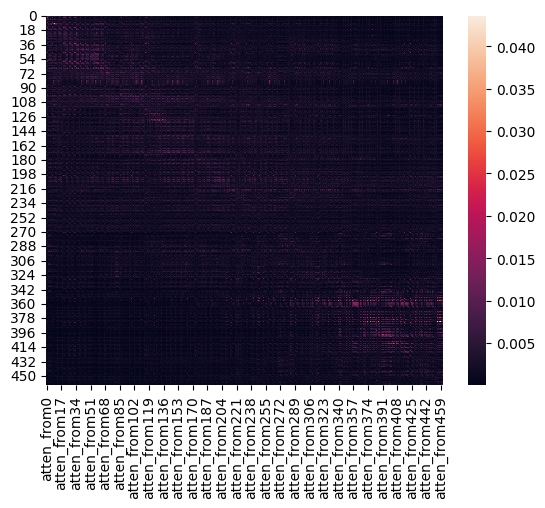

SpeckledBand:Roylott, ranking [1]


,predicate,whom,subject,why,what,where
0,word.predicate:exist,AllTitle:Holmes,SpeckledBand:snake,SpeckledBand:bed,SpeckledBand:bed,SpeckledBand:bed
1,word.predicate:kill,SpeckledBand:Roylott,SpeckledBand:Roylott,SpeckledBand:mansion_of_Roylott,SpeckledBand:safe,SpeckledBand:Julia_s_bedroom
2,word.predicate:have,SpeckledBand:Helen,word.predicate:hear,SilverBlaze:Colonel_Ross,SilverBlaze:Colonel_Ross,SpeckledBand:mansion_of_Roylott
3,word.predicate:hit,SpeckledBand:snake,AllTitle:Holmes,SpeckledBand:Julia_s_bedroom,SpeckledBand:Roylott,SpeckledBand:Roylott
4,word.predicate:sit,SpeckledBand:Julia,SpeckledBand:Helen,ResidentPatient:Helper_boy,SpeckledBand:VentilationHole,SilverBlaze:Colonel_Ross
5,word.predicate:open,SpeckledBand:VentilationHole,SilverBlaze:Colonel_Ross,SpeckledBand:VentilationHole,SpeckledBand:snake,AllTitle:Holmes
6,word.predicate:say,DancingMen:Cubitt,CrookedMan:Barclay,SpeckledBand:Julia,AllTitle:Holmes,AllTitle:Watson
7,word.predicate:marry,AllTitle:Watson,DevilsFoot:window,SpeckledBand:Roylott,SpeckledBand:mansion_of_Roylott,SpeckledBand:house_of_Holmes
8,word.predicate:die,SpeckledBand:bed,SpeckledBand:bed,DateTime:1883-04-01T15:00:00,DateTime:1883-04-01T15:00:00,SpeckledBand:VentilationHole
9,word.predicate:hear,SpeckledBand:1883-04-01T15,word.predicate:see,SpeckledBand:safe,SpeckledBand:1883-04-01T15,ResidentPatient:Helper_boy


442

['SpeckledBand:399', 'kgc:to', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from442
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.019473
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.018303
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.012481
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.011696
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011101
373,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.010993
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.010944
328,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009796
386,SpeckledBand:389,kgc:subject,SpeckledBand:Roylott,0.009556
340,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.009029


----------


443

['SpeckledBand:399', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from443
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010726
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008914
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007054
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006990
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.006785
398,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.006670
346,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.006459
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.006455
343,SpeckledBand:379,kgc:when,SpeckledBand:1873-04-01T15,0.006233
270,SpeckledBand:368,kgc:subject,SpeckledBand:Roma,0.006174


----------


444

['SpeckledBand:399', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from444
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.009754
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.009749
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008479
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008407
375,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007774
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.007348
217,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007226
444,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.007189
425,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.006933
338,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.006731


----------


445

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from445
170,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.004573
263,bos_e,bos_r,bos_e,0.004348
169,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.004334
55,bos_e,bos_r,bos_e,0.004317
50,bos_e,bos_r,bos_e,0.004308
108,bos_e,bos_r,bos_e,0.004280
411,bos_e,bos_r,bos_e,0.004236
44,bos_e,bos_r,bos_e,0.004185
102,bos_e,bos_r,bos_e,0.004165
131,SpeckledBand:344,kgc:what,SpeckledBand:window,0.004151


----------


446

['SpeckledBand:400', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from446
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.017149
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.017084
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.013462
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011797
373,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.010702
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010151
328,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009233
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.009102
417,SpeckledBand:395,kgc:subject,AllTitle:Holmes,0.008626
365,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008607


----------


447

['SpeckledBand:400', 'kgc:hasPredicate', 'word.predicate:bite']

,head,relation,tail,atten_from447
379,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.008707
375,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008286
392,SpeckledBand:390,kgc:subject,SpeckledBand:whip,0.007627
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.007335
217,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007140
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.006931
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.006694
330,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006441
425,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.006355
235,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.006283


----------


448

['SpeckledBand:400', 'kgc:what', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from448
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.012213
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.011349
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.011326
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010577
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.010539
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.009142
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.008727
354,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.008463
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008242
375,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008085


----------


449

['SpeckledBand:400', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from449
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.009380
346,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.009318
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008853
359,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007681
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.007498
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007456
270,SpeckledBand:368,kgc:subject,SpeckledBand:Roma,0.006719
358,SpeckledBand:383,kgc:what,SpeckledBand:384,0.006498
361,SpeckledBand:383,kgc:what,SpeckledBand:387,0.006338
410,SpeckledBand:393,kgc:when,SpeckledBand:069,0.006106


----------


450

['SpeckledBand:400', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from450
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.012054
338,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.008534
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.008518
444,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.007821
333,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.007763
217,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007551
450,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.007323
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.007170
326,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.006528
294,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.006416


----------


451

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from451
169,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.004574
170,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.004532
263,bos_e,bos_r,bos_e,0.004314
50,bos_e,bos_r,bos_e,0.004311
55,bos_e,bos_r,bos_e,0.004300
108,bos_e,bos_r,bos_e,0.004255
44,bos_e,bos_r,bos_e,0.004184
411,bos_e,bos_r,bos_e,0.004171
100,SpeckledBand:338,kgc:when,SpeckledBand:1883-04-02T04,0.004167
102,bos_e,bos_r,bos_e,0.004155


----------


452

['SpeckledBand:401', 'kgc:subject', 'SpeckledBand:Roma']

,head,relation,tail,atten_from452
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.012785
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.011407
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.010696
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.010236
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.009660
365,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008449
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008202
417,SpeckledBand:395,kgc:subject,AllTitle:Holmes,0.008040
380,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.007985
373,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.007752


----------


453

['SpeckledBand:401', 'kgc:hasProperty', 'word.predicate:band']

,head,relation,tail,atten_from453
375,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007208
380,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.006938
179,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.006530
365,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.006332
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.006323
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.006254
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.006022
217,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.005925
219,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.005916
379,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.005890


----------


454

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from454
169,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.004418
170,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.004418
100,SpeckledBand:338,kgc:when,SpeckledBand:1883-04-02T04,0.004281
71,SpeckledBand:333,kgc:what,SpeckledBand:scream,0.004251
50,bos_e,bos_r,bos_e,0.004208
263,bos_e,bos_r,bos_e,0.004190
55,bos_e,bos_r,bos_e,0.004188
108,bos_e,bos_r,bos_e,0.004178
131,SpeckledBand:344,kgc:what,SpeckledBand:window,0.004174
44,bos_e,bos_r,bos_e,0.004102


----------


455

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from455
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.040516
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.028138
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.024964
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.023319
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.016503
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.015468
373,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.014392
365,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.013427
235,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010831
340,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.009963


----------


456

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from456
235,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.013578
379,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.012728
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.010127
217,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009960
375,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.009309
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.008469
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.008030
373,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.008027
278,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.007950
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.007848


----------


457

['mask_e', 'kgc:whom', 'SpeckledBand:Julia']

,head,relation,tail,atten_from457
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.033693
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.027862
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.023730
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.017335
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.013009
373,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.012926
365,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.012336
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.011335
380,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.010951
235,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010929


----------


458

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from458
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.043589
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.026377
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.026171
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.021419
369,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.016982
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.016816
373,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.014140
365,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.013632
380,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.013353
111,SpeckledBand:340,kgc:what,SpeckledBand:handgun,0.011033


----------


459

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from459
401,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.012702
363,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.011289
309,SpeckledBand:374,kgc:to,SpeckledBand:floor,0.010271
344,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010097
432,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.009963
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.009720
444,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.008681
380,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.008278
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.008258
311,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.008256


----------


460

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from460
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.015938
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013726
235,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012210
278,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.010686
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010596
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.009247
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.008956
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008857
292,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.007999
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.007733


----------


461

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from461
382,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.016917
356,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.014642
380,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.012120
377,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.011928
409,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.011220
405,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.011198
360,SpeckledBand:383,kgc:what,SpeckledBand:386,0.010673
396,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.010668
352,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010450
414,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.009934


----------


In [22]:
title = 'SpeckledBand'
victim_name = 'Julia'
killer_name = 'Roylott'
last_index = 401
story_len = 80

df_ranking_SpeckledBand, df_attension_SpeckledBand = main_func01(title, victim_name, killer_name, last_index, story_len)

### 悪魔の足跡１
Who killed the victims? (criminal & explanation)
被害者: Brenda
犯人: Mortimer
犯行動機: 財産

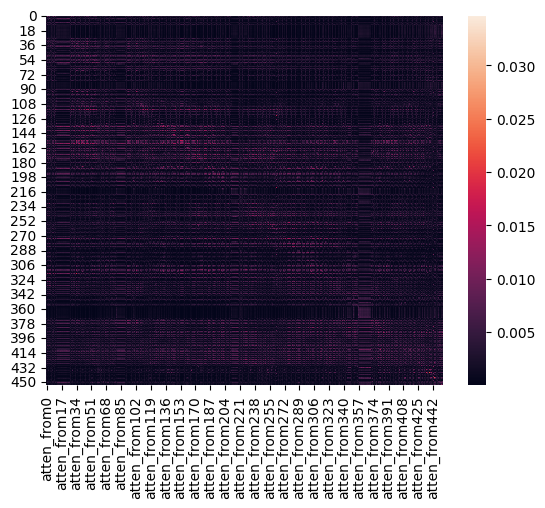

DevilsFoot:Mortimer, ranking [1]


,predicate,whom,subject,why,what,where
0,word.predicate:go,DevilsFoot:Sterndale,DevilsFoot:Sterndale,AllTitle:Watson,ResidentPatient:Percy_Trevelyan,ResidentPatient:Blessington
1,word.predicate:exist,AllTitle:Holmes,DevilsFoot:Mortimer,DevilsFoot:Mortimer,AllTitle:Holmes,AllTitle:Holmes
2,word.predicate:say,DevilsFoot:Mortimer,AllTitle:Holmes,ResidentPatient:Blessington,DevilsFoot:Mortimer,DevilsFoot:Sterndale
3,word.predicate:kill,ResidentPatient:Blessington,ResidentPatient:Percy_Trevelyan,SpeckledBand:mansion_of_Roylott,DevilsFoot:gravel,DevilsFoot:window
4,word.predicate:enter,DevilsFoot:Brenda,DancingMen:Cubitt,ResidentPatient:Percy_Trevelyan,DevilsFoot:Sterndale,ResidentPatient:Percy_Trevelyan
5,word.predicate:examine,ResidentPatient:Percy_Trevelyan,SilverBlaze:Night_of_the_incident,DevilsFoot:gravel,AllTitle:Watson,SilverBlaze:police
6,word.predicate:cannotFind,ACaseOfIdentity:Windibank,DateTime:1883-04-02T04:00:00,DevilsFoot:room,SpeckledBand:Roylott,SpeckledBand:Roylott
7,DevilsFoot:Sterndale,AllTitle:Watson,CrookedMan:Nancy,SpeckledBand:bed,ResidentPatient:Blessington,AllTitle:Watson
8,word.predicate:come,SilverBlaze:Night_of_the_incident,word.predicate:arrive,SilverBlaze:police,SpeckledBand:mansion_of_Roylott,AbbeyGrange:Criminal
9,word.predicate:find,DevilsFoot:Roundhay,ResidentPatient:Blessington,ACaseOfIdentity:Windibank,SpeckledBand:bed,DancingMen:Cubitt


434

['DevilsFoot:487', 'kgc:subject', 'DevilsFoot:Starting_point_of_investigation']

,head,relation,tail,atten_from434
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.018286
302,DevilsFoot:463,kgc:subject,DevilsFoot:Mortimer,0.017325
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.013804
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.013360
134,DevilsFoot:432,kgc:subject,DevilsFoot:Drug,0.012562
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.011170
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.010299
408,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.008763
343,DevilsFoot:471,kgc:subject,DevilsFoot:Mortimer,0.008729
372,DevilsFoot:474,kgc:subject,DevilsFoot:Sterndale,0.008714


----------


435

['DevilsFoot:487', 'kgc:hasProperty', 'word.predicate:gravel']

,head,relation,tail,atten_from435
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.008665
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.008103
372,DevilsFoot:474,kgc:subject,DevilsFoot:Sterndale,0.007617
449,mask_e,kgc:whom,DevilsFoot:Brenda,0.007400
380,DevilsFoot:476,kgc:subject,DevilsFoot:Mortimer,0.006995
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.006778
79,DevilsFoot:422,kgc:subject,DevilsFoot:Roundhay,0.006647
408,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.006268
168,DevilsFoot:438,kgc:whom,DevilsFoot:George,0.006163
167,DevilsFoot:438,kgc:whom,DevilsFoot:Owen,0.006156


----------


436

['DevilsFoot:487', 'kgc:on', 'DevilsFoot:frame_of_Window']

,head,relation,tail,atten_from436
339,DevilsFoot:470,kgc:hasPredicate,word.predicate:decide,0.008471
315,DevilsFoot:465,kgc:hasPredicate,word.predicate:know,0.008470
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.008115
150,DevilsFoot:435,kgc:hasPredicate,word.predicate:contain,0.007929
386,DevilsFoot:477,kgc:hasPredicate,word.predicate:paralyze,0.007596
439,DevilsFoot:488,kgc:hasPredicate,word.predicate:notExist,0.007098
79,DevilsFoot:422,kgc:subject,DevilsFoot:Roundhay,0.006371
415,DevilsFoot:483,kgc:hasPredicate,word.predicate:putOn,0.006350
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.006243
168,DevilsFoot:438,kgc:whom,DevilsFoot:George,0.006137


----------


437

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from437
129,bos_e,bos_r,bos_e,0.004598
78,bos_e,bos_r,bos_e,0.004560
56,DevilsFoot:418,kgc:hasPredicate,word.predicate:leave,0.004515
91,bos_e,bos_r,bos_e,0.004489
133,bos_e,bos_r,bos_e,0.004401
97,bos_e,bos_r,bos_e,0.004375
122,DevilsFoot:429,kgc:hasPredicate,word.predicate:put,0.004346
125,bos_e,bos_r,bos_e,0.004340
27,bos_e,bos_r,bos_e,0.004323
72,bos_e,bos_r,bos_e,0.004319


----------


438

['DevilsFoot:488', 'kgc:subject', 'DevilsFoot:gravel']

,head,relation,tail,atten_from438
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.021922
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.011812
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.010861
408,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.010218
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.009940
149,DevilsFoot:435,kgc:subject,DevilsFoot:powder_medicine,0.009769
134,DevilsFoot:432,kgc:subject,DevilsFoot:Drug,0.009653
372,DevilsFoot:474,kgc:subject,DevilsFoot:Sterndale,0.009385
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.009127
302,DevilsFoot:463,kgc:subject,DevilsFoot:Mortimer,0.008969


----------


439

['DevilsFoot:488', 'kgc:hasPredicate', 'word.predicate:notExist']

,head,relation,tail,atten_from439
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.011520
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.009812
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.008731
138,DevilsFoot:433,kgc:subject,DevilsFoot:sample_of_magic_foot,0.008714
155,DevilsFoot:436,kgc:subject,DevilsFoot:George,0.007952
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.007897
149,DevilsFoot:435,kgc:subject,DevilsFoot:powder_medicine,0.007179
436,DevilsFoot:487,kgc:on,DevilsFoot:frame_of_Window,0.007116
75,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.006988
440,DevilsFoot:488,kgc:where,DevilsFoot:garden_of_pastoral_hall,0.006905


----------


440

['DevilsFoot:488', 'kgc:where', 'DevilsFoot:garden_of_pastoral_hall']

,head,relation,tail,atten_from440
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.014554
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.012009
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.009410
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.007629
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.007342
138,DevilsFoot:433,kgc:subject,DevilsFoot:sample_of_magic_foot,0.006991
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.006729
416,DevilsFoot:483,kgc:what,DevilsFoot:Powder_medicine,0.006476
452,mask_e,kgc:what,mask_e,0.006365
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.006351


----------


441

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from441
75,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.004730
129,bos_e,bos_r,bos_e,0.004362
30,DevilsFoot:413,kgc:what,DevilsFoot:Brenda,0.004302
78,bos_e,bos_r,bos_e,0.004298
122,DevilsFoot:429,kgc:hasPredicate,word.predicate:put,0.004228
91,bos_e,bos_r,bos_e,0.004221
133,bos_e,bos_r,bos_e,0.004150
125,bos_e,bos_r,bos_e,0.004132
97,bos_e,bos_r,bos_e,0.004130
72,bos_e,bos_r,bos_e,0.004105


----------


442

['DevilsFoot:489', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from442
420,DevilsFoot:484,kgc:hasPredicate,word.predicate:stand,0.017734
430,DevilsFoot:486,kgc:hasPredicate,word.predicate:die,0.012972
381,DevilsFoot:476,kgc:hasPredicate,word.predicate:see,0.012715
443,DevilsFoot:489,kgc:hasPredicate,word.predicate:find,0.011896
386,DevilsFoot:477,kgc:hasPredicate,word.predicate:paralyze,0.011303
439,DevilsFoot:488,kgc:hasPredicate,word.predicate:notExist,0.010319
293,DevilsFoot:461,kgc:hasPredicate,word.predicate:become,0.010173
211,DevilsFoot:446,kgc:hasPredicate,word.predicate:consider,0.009804
173,DevilsFoot:439,kgc:hasPredicate,word.predicate:come,0.008898
190,DevilsFoot:442,kgc:hasPredicate,word.predicate:teach,0.008668


----------


443

['DevilsFoot:489', 'kgc:hasPredicate', 'word.predicate:find']

,head,relation,tail,atten_from443
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.012892
452,mask_e,kgc:what,mask_e,0.011101
416,DevilsFoot:483,kgc:what,DevilsFoot:Powder_medicine,0.008292
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.008251
445,DevilsFoot:489,kgc:where,DevilsFoot:garden_of_Cottage_of_Sterndale,0.007232
382,DevilsFoot:476,kgc:what,DevilsFoot:revolver,0.007030
146,DevilsFoot:434,kgc:what,DevilsFoot:literature_of_toxicology,0.006347
440,DevilsFoot:488,kgc:where,DevilsFoot:garden_of_pastoral_hall,0.005896
145,DevilsFoot:434,kgc:what,DevilsFoot:literature_of_pharmacy,0.005713
345,DevilsFoot:471,kgc:what,DevilsFoot:same_fate_of_Owen,0.005641


----------


444

['DevilsFoot:489', 'kgc:what', 'DevilsFoot:gravel']

,head,relation,tail,atten_from444
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.021174
452,mask_e,kgc:what,mask_e,0.016954
426,DevilsFoot:485,kgc:what,DevilsFoot:gun,0.011320
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.010243
445,DevilsFoot:489,kgc:where,DevilsFoot:garden_of_Cottage_of_Sterndale,0.009503
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.007935
453,mask_e,kgc:where,mask_e,0.007315
416,DevilsFoot:483,kgc:what,DevilsFoot:Powder_medicine,0.007255
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.006899
440,DevilsFoot:488,kgc:where,DevilsFoot:garden_of_pastoral_hall,0.006801


----------


445

['DevilsFoot:489', 'kgc:where', 'DevilsFoot:garden_of_Cottage_of_Sterndale']

,head,relation,tail,atten_from445
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.011042
452,mask_e,kgc:what,mask_e,0.009808
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.008943
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.008620
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007512
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.007504
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.007023
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.006961
311,DevilsFoot:464,kgc:infoSource,DevilsFoot:Sterndale,0.006680
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.006601


----------


446

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from446
75,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.004926
30,DevilsFoot:413,kgc:what,DevilsFoot:Brenda,0.004662
129,bos_e,bos_r,bos_e,0.004325
78,bos_e,bos_r,bos_e,0.004230
91,bos_e,bos_r,bos_e,0.004194
52,DevilsFoot:417,kgc:what,DevilsFoot:Former_wife,0.004171
97,bos_e,bos_r,bos_e,0.004113
125,bos_e,bos_r,bos_e,0.004113
133,bos_e,bos_r,bos_e,0.004109
122,DevilsFoot:429,kgc:hasPredicate,word.predicate:put,0.004078


----------


447

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from447
166,DevilsFoot:438,kgc:hasPredicate,word.predicate:meet,0.007471
230,DevilsFoot:448,kgc:infoSource,DevilsFoot:Sterndale,0.006140
233,DevilsFoot:449,kgc:hasPredicate,word.predicate:go,0.006004
237,DevilsFoot:450,kgc:subject,DevilsFoot:Sterndale,0.005862
257,DevilsFoot:454,kgc:hasPredicate,word.predicate:come,0.005771
405,DevilsFoot:481,kgc:infoSource,DevilsFoot:Sterndale,0.005727
259,DevilsFoot:454,kgc:infoSource,DevilsFoot:Sterndale,0.005678
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.005555
424,DevilsFoot:485,kgc:subject,DevilsFoot:Sterndale,0.005395
403,DevilsFoot:481,kgc:subject,DevilsFoot:Mortimer,0.005364


----------


448

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from448
452,mask_e,kgc:what,mask_e,0.009129
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.008445
346,DevilsFoot:471,kgc:what,DevilsFoot:same_fate_of__George,0.007192
92,DevilsFoot:423,kgc:subject,DevilsFoot:Sterndale,0.006845
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.006473
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.006283
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.006231
447,mask_e,kgc:infoSource,AllTitle:Holmes,0.006228
406,DevilsFoot:481,kgc:from,DevilsFoot:room,0.006102
79,DevilsFoot:422,kgc:subject,DevilsFoot:Roundhay,0.006090


----------


449

['mask_e', 'kgc:whom', 'DevilsFoot:Brenda']

,head,relation,tail,atten_from449
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.009692
92,DevilsFoot:423,kgc:subject,DevilsFoot:Sterndale,0.009523
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.009154
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.008603
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.007993
403,DevilsFoot:481,kgc:subject,DevilsFoot:Mortimer,0.007551
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007506
259,DevilsFoot:454,kgc:infoSource,DevilsFoot:Sterndale,0.007473
93,DevilsFoot:423,kgc:subject,DevilsFoot:Brenda,0.007419
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.007404


----------


450

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from450
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.008439
153,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.008119
419,DevilsFoot:484,kgc:subject,DevilsFoot:Sterndale,0.008083
259,DevilsFoot:454,kgc:infoSource,DevilsFoot:Sterndale,0.007998
450,mask_e,kgc:subject,mask_e,0.007614
172,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.007559
92,DevilsFoot:423,kgc:subject,DevilsFoot:Sterndale,0.007476
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.007450
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.007441
157,DevilsFoot:436,kgc:infoSource,DevilsFoot:Sterndale,0.007413


----------


451

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from451
452,mask_e,kgc:what,mask_e,0.016772
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.009654
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.009524
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.009451
376,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.008861
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.008526
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.008313
450,mask_e,kgc:subject,mask_e,0.008214
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.007934
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.007792


----------


452

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from452
452,mask_e,kgc:what,mask_e,0.034653
453,mask_e,kgc:where,mask_e,0.012218
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.008873
450,mask_e,kgc:subject,mask_e,0.008451
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.007846
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.007327
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.007288
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007143
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.006502
422,DevilsFoot:484,kgc:infoSource,DevilsFoot:Sterndale,0.006485


----------


453

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from453
452,mask_e,kgc:what,mask_e,0.013831
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.010611
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.010329
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.008861
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.008631
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.007959
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.007809
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.007757
449,mask_e,kgc:whom,DevilsFoot:Brenda,0.007478
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.007231


----------


In [24]:
title = 'DevilsFoot'
victim_name = 'Brenda'
killer_name = 'Mortimer'
last_index = 489
story_len = 80
df_ranking_DevilsFoot1, df_attension_DevilsFoot1 = main_func01(title, victim_name, killer_name, last_index, story_len)

### 悪魔の足跡2
Who killed the victims? (criminal & explanation)
被害者: Mortimer
犯人: 
犯行動機: 恋人の敵

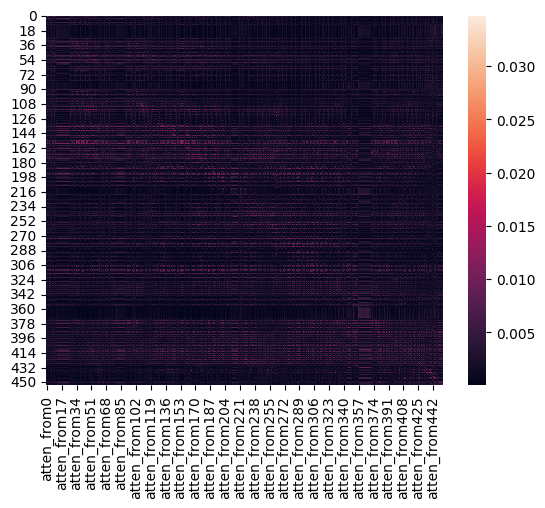

DevilsFoot:Sterndale, ranking [0]


,predicate,whom,subject,why,what,where
0,word.predicate:go,DevilsFoot:Mortimer,DevilsFoot:Sterndale,AllTitle:Watson,AllTitle:Holmes,ResidentPatient:Blessington
1,word.predicate:exist,DevilsFoot:Sterndale,DevilsFoot:Mortimer,DevilsFoot:Mortimer,ResidentPatient:Percy_Trevelyan,DevilsFoot:Sterndale
2,word.predicate:say,AllTitle:Holmes,AllTitle:Holmes,ResidentPatient:Blessington,DevilsFoot:Mortimer,AllTitle:Holmes
3,word.predicate:enter,ResidentPatient:Percy_Trevelyan,ResidentPatient:Percy_Trevelyan,SpeckledBand:mansion_of_Roylott,DevilsFoot:gravel,DevilsFoot:window
4,word.predicate:kill,ACaseOfIdentity:Windibank,DancingMen:Cubitt,ResidentPatient:Percy_Trevelyan,DevilsFoot:Sterndale,ResidentPatient:Percy_Trevelyan
5,word.predicate:examine,AllTitle:Watson,SilverBlaze:Night_of_the_incident,DevilsFoot:gravel,AllTitle:Watson,SilverBlaze:police
6,word.predicate:come,ResidentPatient:Blessington,DateTime:1883-04-02T04:00:00,SpeckledBand:bed,SpeckledBand:Roylott,SpeckledBand:Roylott
7,word.predicate:cannotFind,DevilsFoot:Brenda,CrookedMan:Nancy,DevilsFoot:room,ResidentPatient:Blessington,AllTitle:Watson
8,DevilsFoot:Sterndale,SilverBlaze:Night_of_the_incident,word.predicate:arrive,DevilsFoot:cottage_of_Pordeux_Bay,SilverBlaze:police,DevilsFoot:Mortimer
9,word.predicate:goOut,DevilsFoot:Roundhay,ACaseOfIdentity:Windibank,ACaseOfIdentity:Windibank,SpeckledBand:bed,AbbeyGrange:Criminal


434

['DevilsFoot:487', 'kgc:subject', 'DevilsFoot:Starting_point_of_investigation']

,head,relation,tail,atten_from434
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.018027
302,DevilsFoot:463,kgc:subject,DevilsFoot:Mortimer,0.017199
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.013824
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.013292
134,DevilsFoot:432,kgc:subject,DevilsFoot:Drug,0.012362
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.011259
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.010195
408,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.008800
372,DevilsFoot:474,kgc:subject,DevilsFoot:Sterndale,0.008715
343,DevilsFoot:471,kgc:subject,DevilsFoot:Mortimer,0.008693


----------


435

['DevilsFoot:487', 'kgc:hasProperty', 'word.predicate:gravel']

,head,relation,tail,atten_from435
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.008722
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.008418
449,mask_e,kgc:whom,DevilsFoot:Mortimer,0.007794
372,DevilsFoot:474,kgc:subject,DevilsFoot:Sterndale,0.007597
380,DevilsFoot:476,kgc:subject,DevilsFoot:Mortimer,0.006969
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.006853
79,DevilsFoot:422,kgc:subject,DevilsFoot:Roundhay,0.006453
408,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.006298
168,DevilsFoot:438,kgc:whom,DevilsFoot:George,0.006148
167,DevilsFoot:438,kgc:whom,DevilsFoot:Owen,0.006129


----------


436

['DevilsFoot:487', 'kgc:on', 'DevilsFoot:frame_of_Window']

,head,relation,tail,atten_from436
315,DevilsFoot:465,kgc:hasPredicate,word.predicate:know,0.008480
339,DevilsFoot:470,kgc:hasPredicate,word.predicate:decide,0.008454
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.008158
150,DevilsFoot:435,kgc:hasPredicate,word.predicate:contain,0.007731
386,DevilsFoot:477,kgc:hasPredicate,word.predicate:paralyze,0.007482
439,DevilsFoot:488,kgc:hasPredicate,word.predicate:notExist,0.006734
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.006416
415,DevilsFoot:483,kgc:hasPredicate,word.predicate:putOn,0.006306
79,DevilsFoot:422,kgc:subject,DevilsFoot:Roundhay,0.006219
168,DevilsFoot:438,kgc:whom,DevilsFoot:George,0.006154


----------


437

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from437
129,bos_e,bos_r,bos_e,0.004602
78,bos_e,bos_r,bos_e,0.004566
56,DevilsFoot:418,kgc:hasPredicate,word.predicate:leave,0.004505
91,bos_e,bos_r,bos_e,0.004491
133,bos_e,bos_r,bos_e,0.004405
97,bos_e,bos_r,bos_e,0.004376
125,bos_e,bos_r,bos_e,0.004343
122,DevilsFoot:429,kgc:hasPredicate,word.predicate:put,0.004342
27,bos_e,bos_r,bos_e,0.004327
72,bos_e,bos_r,bos_e,0.004324


----------


438

['DevilsFoot:488', 'kgc:subject', 'DevilsFoot:gravel']

,head,relation,tail,atten_from438
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.021545
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.011913
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.010724
408,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.010219
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.009794
134,DevilsFoot:432,kgc:subject,DevilsFoot:Drug,0.009488
372,DevilsFoot:474,kgc:subject,DevilsFoot:Sterndale,0.009401
149,DevilsFoot:435,kgc:subject,DevilsFoot:powder_medicine,0.009346
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.009075
302,DevilsFoot:463,kgc:subject,DevilsFoot:Mortimer,0.008828


----------


439

['DevilsFoot:488', 'kgc:hasPredicate', 'word.predicate:notExist']

,head,relation,tail,atten_from439
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.011926
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.009737
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.008968
138,DevilsFoot:433,kgc:subject,DevilsFoot:sample_of_magic_foot,0.008588
155,DevilsFoot:436,kgc:subject,DevilsFoot:George,0.007864
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.007795
436,DevilsFoot:487,kgc:on,DevilsFoot:frame_of_Window,0.007378
440,DevilsFoot:488,kgc:where,DevilsFoot:garden_of_pastoral_hall,0.007070
149,DevilsFoot:435,kgc:subject,DevilsFoot:powder_medicine,0.006948
75,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.006929


----------


440

['DevilsFoot:488', 'kgc:where', 'DevilsFoot:garden_of_pastoral_hall']

,head,relation,tail,atten_from440
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.014376
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.012732
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.009479
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.007629
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.007331
138,DevilsFoot:433,kgc:subject,DevilsFoot:sample_of_magic_foot,0.007040
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.006834
452,mask_e,kgc:what,mask_e,0.006812
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.006470
416,DevilsFoot:483,kgc:what,DevilsFoot:Powder_medicine,0.006429


----------


441

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from441
75,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.004731
129,bos_e,bos_r,bos_e,0.004370
78,bos_e,bos_r,bos_e,0.004308
30,DevilsFoot:413,kgc:what,DevilsFoot:Brenda,0.004297
91,bos_e,bos_r,bos_e,0.004227
122,DevilsFoot:429,kgc:hasPredicate,word.predicate:put,0.004223
133,bos_e,bos_r,bos_e,0.004157
125,bos_e,bos_r,bos_e,0.004138
97,bos_e,bos_r,bos_e,0.004134
72,bos_e,bos_r,bos_e,0.004115


----------


442

['DevilsFoot:489', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from442
420,DevilsFoot:484,kgc:hasPredicate,word.predicate:stand,0.017808
430,DevilsFoot:486,kgc:hasPredicate,word.predicate:die,0.013102
381,DevilsFoot:476,kgc:hasPredicate,word.predicate:see,0.012471
443,DevilsFoot:489,kgc:hasPredicate,word.predicate:find,0.011982
386,DevilsFoot:477,kgc:hasPredicate,word.predicate:paralyze,0.011296
439,DevilsFoot:488,kgc:hasPredicate,word.predicate:notExist,0.010485
293,DevilsFoot:461,kgc:hasPredicate,word.predicate:become,0.010463
211,DevilsFoot:446,kgc:hasPredicate,word.predicate:consider,0.009701
173,DevilsFoot:439,kgc:hasPredicate,word.predicate:come,0.009122
190,DevilsFoot:442,kgc:hasPredicate,word.predicate:teach,0.008552


----------


443

['DevilsFoot:489', 'kgc:hasPredicate', 'word.predicate:find']

,head,relation,tail,atten_from443
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.013314
452,mask_e,kgc:what,mask_e,0.011709
416,DevilsFoot:483,kgc:what,DevilsFoot:Powder_medicine,0.008267
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.008191
445,DevilsFoot:489,kgc:where,DevilsFoot:garden_of_Cottage_of_Sterndale,0.007496
382,DevilsFoot:476,kgc:what,DevilsFoot:revolver,0.007002
146,DevilsFoot:434,kgc:what,DevilsFoot:literature_of_toxicology,0.006363
440,DevilsFoot:488,kgc:where,DevilsFoot:garden_of_pastoral_hall,0.006132
145,DevilsFoot:434,kgc:what,DevilsFoot:literature_of_pharmacy,0.005751
345,DevilsFoot:471,kgc:what,DevilsFoot:same_fate_of_Owen,0.005685


----------


444

['DevilsFoot:489', 'kgc:what', 'DevilsFoot:gravel']

,head,relation,tail,atten_from444
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.021238
452,mask_e,kgc:what,mask_e,0.017540
426,DevilsFoot:485,kgc:what,DevilsFoot:gun,0.011215
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.010024
445,DevilsFoot:489,kgc:where,DevilsFoot:garden_of_Cottage_of_Sterndale,0.009346
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.007955
453,mask_e,kgc:where,mask_e,0.007502
416,DevilsFoot:483,kgc:what,DevilsFoot:Powder_medicine,0.007127
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.006996
440,DevilsFoot:488,kgc:where,DevilsFoot:garden_of_pastoral_hall,0.006759


----------


445

['DevilsFoot:489', 'kgc:where', 'DevilsFoot:garden_of_Cottage_of_Sterndale']

,head,relation,tail,atten_from445
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.011346
452,mask_e,kgc:what,mask_e,0.010361
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.008808
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.008723
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007664
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.007638
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.007113
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.006996
311,DevilsFoot:464,kgc:infoSource,DevilsFoot:Sterndale,0.006917
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.006744


----------


446

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from446
75,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.004933
30,DevilsFoot:413,kgc:what,DevilsFoot:Brenda,0.004662
129,bos_e,bos_r,bos_e,0.004338
78,bos_e,bos_r,bos_e,0.004247
91,bos_e,bos_r,bos_e,0.004205
52,DevilsFoot:417,kgc:what,DevilsFoot:Former_wife,0.004181
97,bos_e,bos_r,bos_e,0.004123
125,bos_e,bos_r,bos_e,0.004122
133,bos_e,bos_r,bos_e,0.004120
122,DevilsFoot:429,kgc:hasPredicate,word.predicate:put,0.004075


----------


447

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from447
166,DevilsFoot:438,kgc:hasPredicate,word.predicate:meet,0.007387
230,DevilsFoot:448,kgc:infoSource,DevilsFoot:Sterndale,0.006243
233,DevilsFoot:449,kgc:hasPredicate,word.predicate:go,0.006069
237,DevilsFoot:450,kgc:subject,DevilsFoot:Sterndale,0.005930
257,DevilsFoot:454,kgc:hasPredicate,word.predicate:come,0.005900
405,DevilsFoot:481,kgc:infoSource,DevilsFoot:Sterndale,0.005860
259,DevilsFoot:454,kgc:infoSource,DevilsFoot:Sterndale,0.005796
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.005629
424,DevilsFoot:485,kgc:subject,DevilsFoot:Sterndale,0.005428
403,DevilsFoot:481,kgc:subject,DevilsFoot:Mortimer,0.005347


----------


448

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from448
452,mask_e,kgc:what,mask_e,0.010315
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.008408
346,DevilsFoot:471,kgc:what,DevilsFoot:same_fate_of__George,0.007003
449,mask_e,kgc:whom,DevilsFoot:Mortimer,0.006465
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.006324
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.006322
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.006253
447,mask_e,kgc:infoSource,AllTitle:Holmes,0.006237
92,DevilsFoot:423,kgc:subject,DevilsFoot:Sterndale,0.006173
372,DevilsFoot:474,kgc:subject,DevilsFoot:Sterndale,0.006099


----------


449

['mask_e', 'kgc:whom', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from449
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.009605
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.008961
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.008936
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.008581
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.008319
403,DevilsFoot:481,kgc:subject,DevilsFoot:Mortimer,0.008197
449,mask_e,kgc:whom,DevilsFoot:Mortimer,0.008062
259,DevilsFoot:454,kgc:infoSource,DevilsFoot:Sterndale,0.007842
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.007733
343,DevilsFoot:471,kgc:subject,DevilsFoot:Mortimer,0.007625


----------


450

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from450
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.008650
259,DevilsFoot:454,kgc:infoSource,DevilsFoot:Sterndale,0.008195
419,DevilsFoot:484,kgc:subject,DevilsFoot:Sterndale,0.008033
153,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.007820
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.007590
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.007560
172,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.007542
256,DevilsFoot:454,kgc:subject,DevilsFoot:Sterndale,0.007529
157,DevilsFoot:436,kgc:infoSource,DevilsFoot:Sterndale,0.007342
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007322


----------


451

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from451
452,mask_e,kgc:what,mask_e,0.018092
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.009662
438,DevilsFoot:488,kgc:subject,DevilsFoot:gravel,0.009426
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.009290
376,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.008796
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.008540
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.008501
449,mask_e,kgc:whom,DevilsFoot:Mortimer,0.008404
434,DevilsFoot:487,kgc:subject,DevilsFoot:Starting_point_of_investigation,0.007938
453,mask_e,kgc:where,mask_e,0.007876


----------


452

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from452
452,mask_e,kgc:what,mask_e,0.034731
453,mask_e,kgc:where,mask_e,0.012671
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.008905
444,DevilsFoot:489,kgc:what,DevilsFoot:gravel,0.008046
450,mask_e,kgc:subject,mask_e,0.007919
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.007324
410,DevilsFoot:482,kgc:what,DevilsFoot:fire,0.007288
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007196
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.006613
422,DevilsFoot:484,kgc:infoSource,DevilsFoot:Sterndale,0.006562


----------


453

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from453
452,mask_e,kgc:what,mask_e,0.014665
431,DevilsFoot:486,kgc:infoSource,DevilsFoot:Sterndale,0.010810
389,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.010447
391,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.009130
394,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.008883
387,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.008202
308,DevilsFoot:464,kgc:subject,DevilsFoot:Mortimer,0.008021
429,DevilsFoot:486,kgc:subject,DevilsFoot:Mortimer,0.007910
449,mask_e,kgc:whom,DevilsFoot:Mortimer,0.007624
419,DevilsFoot:484,kgc:subject,DevilsFoot:Sterndale,0.007032


----------


In [26]:
title = 'DevilsFoot'
victim_name = 'Mortimer'
killer_name = 'Sterndale'
last_index = 489
story_len = 80
df_ranking_DevilsFoot2, df_attension_DevilsFoot2 = main_func01(title, victim_name, killer_name, last_index, story_len)

### 背中の曲がった男: 
Why did Barclay die?
被害者: Barclay
犯人: 
犯行動機: 

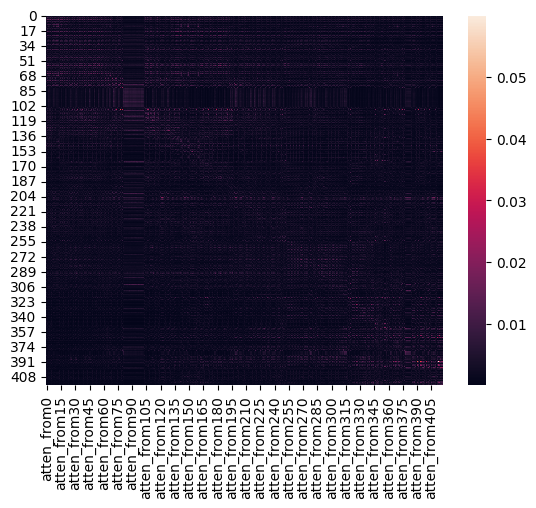

,predicate,whom,subject,why,what,where
0,word.predicate:exist,CrookedMan:Barclay,CrookedMan:Barclay,CrookedMan:Henry,CrookedMan:Henry,CrookedMan:living_room
1,word.predicate:have,CrookedMan:living_room,AllTitle:Holmes,word.predicate:want,AllTitle:Holmes,AllTitle:Holmes
2,word.predicate:find,CrookedMan:Henry,ACaseOfIdentity:Sutherland,CrookedMan:beast,CrookedMan:beast,CrookedMan:Henry
3,word.predicate:enter,AllTitle:Holmes,CrookedMan:beast,DevilsFoot:Case_1,CrookedMan:living_room,CrookedMan:beast
4,word.predicate:see,CrookedMan:Nancy,SilverBlaze:Fitzroy_Simpson,ACaseOfIdentity:Sutherland,ACaseOfIdentity:Windibank,word.predicate:have
5,word.predicate:go,CrookedMan:Murphy,CrookedMan:Henry,word.predicate:see,word.predicate:see,SpeckledBand:safe
6,word.predicate:die,word.predicate:hear,AbbeyGrange:Lady_Brackenstall,word.predicate:have,CrookedMan:Royal_Mallows,ACaseOfIdentity:Sutherland
7,word.predicate:meet,ResidentPatient:Young_man,CrookedMan:Royal_Mallows,CrookedMan:living_room,word.predicate:have,word.predicate:see
8,word.predicate:confirm,ACaseOfIdentity:Windibank,AllTitle:Watson,AbbeyGrange:Thought_of_Holmes,word.predicate:want,CrookedMan:086
9,word.predicate:kill,bos_e,ACaseOfIdentity:Windibank,word.predicate:meet,ACaseOfIdentity:Sutherland,ACaseOfIdentity:Windibank


398

['CrookedMan:371', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from398
105,CrookedMan:310,kgc:hasPredicate,word.predicate:talk,0.015565
396,CrookedMan:371,kgc:hasPredicate,word.predicate:sin,0.012250
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.009885
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.009776
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.008814
373,CrookedMan:367,kgc:hasPredicate,word.predicate:ask,0.007874
378,CrookedMan:368,kgc:hasPredicate,word.predicate:say,0.007310
391,CrookedMan:370,kgc:hasPredicate,word.predicate:sin,0.007105
347,CrookedMan:363,kgc:hasPredicate,word.predicate:go,0.007098
352,CrookedMan:363a,kgc:hasPredicate,word.predicate:ask,0.006973


----------


399

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from399
146,CrookedMan:318,kgc:what,CrookedMan:318a,0.009663
79,bos_e,bos_r,bos_e,0.005351
133,CrookedMan:316,kgc:what,CrookedMan:317,0.005338
384,bos_e,bos_r,bos_e,0.005121
74,bos_e,bos_r,bos_e,0.005038
28,bos_e,bos_r,bos_e,0.004920
103,bos_e,bos_r,bos_e,0.004904
43,bos_e,bos_r,bos_e,0.004843
280,bos_e,bos_r,bos_e,0.004834
33,bos_e,bos_r,bos_e,0.004805


----------


400

['CrookedMan:372', 'kgc:subject', 'CrookedMan:sin_of_Davide']

,head,relation,tail,atten_from400
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.028446
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.017502
361,CrookedMan:365,kgc:subject,CrookedMan:Murphy,0.015024
318,CrookedMan:356,kgc:subject,CrookedMan:Henry,0.013476
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.012197
414,mask_e,kgc:subject,CrookedMan:Barclay,0.011878
326,CrookedMan:358,kgc:subject,CrookedMan:Barclay,0.009945
365,CrookedMan:366,kgc:subject,CrookedMan:Barclay,0.008881
354,CrookedMan:363a,kgc:whom,CrookedMan:Murphy,0.008387
359,CrookedMan:364,kgc:whom,CrookedMan:Murphy,0.008003


----------


401

['CrookedMan:372', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from401
363,CrookedMan:365,kgc:what,CrookedMan:366,0.011813
205,CrookedMan:330,kgc:what,CrookedMan:criminal,0.010835
207,CrookedMan:330,kgc:infoSource,CrookedMan:Henry,0.008739
359,CrookedMan:364,kgc:whom,CrookedMan:Murphy,0.008700
216,CrookedMan:331a,kgc:what,CrookedMan:secret_of_Henry,0.007772
353,CrookedMan:363a,kgc:what,CrookedMan:progress_of_incedent,0.007516
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.007276
206,CrookedMan:330,kgc:whom,CrookedMan:Henry,0.007272
361,CrookedMan:365,kgc:subject,CrookedMan:Murphy,0.007089
354,CrookedMan:363a,kgc:whom,CrookedMan:Murphy,0.006802


----------


402

['CrookedMan:372', 'kgc:where', 'CrookedMan:episode_of_Uriah_and_Bathsheba']

,head,relation,tail,atten_from402
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.019108
363,CrookedMan:365,kgc:what,CrookedMan:366,0.017346
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.012441
353,CrookedMan:363a,kgc:what,CrookedMan:progress_of_incedent,0.011647
205,CrookedMan:330,kgc:what,CrookedMan:criminal,0.010025
310,CrookedMan:353,kgc:what,CrookedMan:cobra,0.009517
303,CrookedMan:352,kgc:what,CrookedMan:cobra,0.009192
413,mask_e,kgc:whom,mask_e,0.008586
408,CrookedMan:373,kgc:what,CrookedMan:postscript_of_Samuel,0.008458
380,CrookedMan:368,kgc:what,CrookedMan:370,0.008114


----------


403

['CrookedMan:372', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from403
105,CrookedMan:310,kgc:hasPredicate,word.predicate:talk,0.018190
396,CrookedMan:371,kgc:hasPredicate,word.predicate:sin,0.015433
378,CrookedMan:368,kgc:hasPredicate,word.predicate:say,0.010161
373,CrookedMan:367,kgc:hasPredicate,word.predicate:ask,0.010100
352,CrookedMan:363a,kgc:hasPredicate,word.predicate:ask,0.010058
254,CrookedMan:339,kgc:hasPredicate,word.predicate:putOut,0.010016
302,CrookedMan:352,kgc:hasPredicate,word.predicate:catch,0.009904
81,CrookedMan:309,kgc:hasPredicate,word.predicate:say,0.009255
347,CrookedMan:363,kgc:hasPredicate,word.predicate:go,0.008879
309,CrookedMan:353,kgc:hasPredicate,word.predicate:catch,0.008566


----------


404

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from404
146,CrookedMan:318,kgc:what,CrookedMan:318a,0.011175
133,CrookedMan:316,kgc:what,CrookedMan:317,0.005577
79,bos_e,bos_r,bos_e,0.005262
384,bos_e,bos_r,bos_e,0.005079
74,bos_e,bos_r,bos_e,0.004980
28,bos_e,bos_r,bos_e,0.004828
103,bos_e,bos_r,bos_e,0.004796
43,bos_e,bos_r,bos_e,0.004765
270,bos_e,bos_r,bos_e,0.004737
280,bos_e,bos_r,bos_e,0.004720


----------


405

['CrookedMan:373', 'kgc:subject', 'CrookedMan:episode_of_Uriah_and_Bathsheba']

,head,relation,tail,atten_from405
361,CrookedMan:365,kgc:subject,CrookedMan:Murphy,0.017153
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.016946
363,CrookedMan:365,kgc:what,CrookedMan:366,0.013582
414,mask_e,kgc:subject,CrookedMan:Barclay,0.012138
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.010859
338,CrookedMan:361,kgc:subject,CrookedMan:Henry,0.010192
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.009293
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.009179
367,CrookedMan:366,kgc:infoSource,CrookedMan:Murphy,0.008137
359,CrookedMan:364,kgc:whom,CrookedMan:Murphy,0.008073


----------


406

['CrookedMan:373', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from406
205,CrookedMan:330,kgc:what,CrookedMan:criminal,0.015576
363,CrookedMan:365,kgc:what,CrookedMan:366,0.014051
207,CrookedMan:330,kgc:infoSource,CrookedMan:Henry,0.010785
12,CrookedMan:295,kgc:time,DateTime:1867-01-01T00:00:00,0.010573
338,CrookedMan:361,kgc:subject,CrookedMan:Henry,0.009318
335,CrookedMan:360,kgc:what,CrookedMan:guilt,0.009255
206,CrookedMan:330,kgc:whom,CrookedMan:Henry,0.009189
361,CrookedMan:365,kgc:subject,CrookedMan:Murphy,0.008173
407,CrookedMan:373,kgc:what,CrookedMan:preface_of_Samuel,0.008020
359,CrookedMan:364,kgc:whom,CrookedMan:Murphy,0.007689


----------


407

['CrookedMan:373', 'kgc:what', 'CrookedMan:preface_of_Samuel']

,head,relation,tail,atten_from407
205,CrookedMan:330,kgc:what,CrookedMan:criminal,0.018176
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.016310
363,CrookedMan:365,kgc:what,CrookedMan:366,0.014613
408,CrookedMan:373,kgc:what,CrookedMan:postscript_of_Samuel,0.011908
153,CrookedMan:318a,kgc:what,CrookedMan:086,0.011464
335,CrookedMan:360,kgc:what,CrookedMan:guilt,0.011392
353,CrookedMan:363a,kgc:what,CrookedMan:progress_of_incedent,0.010472
407,CrookedMan:373,kgc:what,CrookedMan:preface_of_Samuel,0.010184
207,CrookedMan:330,kgc:infoSource,CrookedMan:Henry,0.008950
367,CrookedMan:366,kgc:infoSource,CrookedMan:Murphy,0.008633


----------


408

['CrookedMan:373', 'kgc:what', 'CrookedMan:postscript_of_Samuel']

,head,relation,tail,atten_from408
205,CrookedMan:330,kgc:what,CrookedMan:criminal,0.018586
363,CrookedMan:365,kgc:what,CrookedMan:366,0.016705
153,CrookedMan:318a,kgc:what,CrookedMan:086,0.014611
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.013487
408,CrookedMan:373,kgc:what,CrookedMan:postscript_of_Samuel,0.011945
335,CrookedMan:360,kgc:what,CrookedMan:guilt,0.011574
367,CrookedMan:366,kgc:infoSource,CrookedMan:Murphy,0.010782
207,CrookedMan:330,kgc:infoSource,CrookedMan:Henry,0.010646
353,CrookedMan:363a,kgc:what,CrookedMan:progress_of_incedent,0.010605
407,CrookedMan:373,kgc:what,CrookedMan:preface_of_Samuel,0.009431


----------


409

['CrookedMan:373', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from409
105,CrookedMan:310,kgc:hasPredicate,word.predicate:talk,0.012273
396,CrookedMan:371,kgc:hasPredicate,word.predicate:sin,0.011768
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.010866
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.009305
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.007852
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.007623
391,CrookedMan:370,kgc:hasPredicate,word.predicate:sin,0.007574
378,CrookedMan:368,kgc:hasPredicate,word.predicate:say,0.007327
412,mask_e,kgc:hasPredicate,word.predicate:die,0.006709
373,CrookedMan:367,kgc:hasPredicate,word.predicate:ask,0.006570


----------


410

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from410
146,CrookedMan:318,kgc:what,CrookedMan:318a,0.011310
79,bos_e,bos_r,bos_e,0.005303
133,CrookedMan:316,kgc:what,CrookedMan:317,0.005267
384,bos_e,bos_r,bos_e,0.005112
74,bos_e,bos_r,bos_e,0.005010
28,bos_e,bos_r,bos_e,0.004868
103,bos_e,bos_r,bos_e,0.004867
270,bos_e,bos_r,bos_e,0.004802
43,bos_e,bos_r,bos_e,0.004786
280,bos_e,bos_r,bos_e,0.004777


----------


411

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from411
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.020974
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.016703
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.013300
414,mask_e,kgc:subject,CrookedMan:Barclay,0.012059
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.009866
396,CrookedMan:371,kgc:hasPredicate,word.predicate:sin,0.009817
105,CrookedMan:310,kgc:hasPredicate,word.predicate:talk,0.009745
361,CrookedMan:365,kgc:subject,CrookedMan:Murphy,0.009091
73,CrookedMan:306,kgc:infoSource,CrookedMan:Henry,0.007276
391,CrookedMan:370,kgc:hasPredicate,word.predicate:sin,0.007185


----------


412

['mask_e', 'kgc:hasPredicate', 'word.predicate:die']

,head,relation,tail,atten_from412
363,CrookedMan:365,kgc:what,CrookedMan:366,0.027574
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.015352
205,CrookedMan:330,kgc:what,CrookedMan:criminal,0.014904
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.013721
207,CrookedMan:330,kgc:infoSource,CrookedMan:Henry,0.012602
361,CrookedMan:365,kgc:subject,CrookedMan:Murphy,0.010867
338,CrookedMan:361,kgc:subject,CrookedMan:Henry,0.010841
353,CrookedMan:363a,kgc:what,CrookedMan:progress_of_incedent,0.010735
335,CrookedMan:360,kgc:what,CrookedMan:guilt,0.010617
359,CrookedMan:364,kgc:whom,CrookedMan:Murphy,0.010555


----------


413

['mask_e', 'kgc:whom', 'mask_e']

,head,relation,tail,atten_from413
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.059879
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.022499
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.021691
414,mask_e,kgc:subject,CrookedMan:Barclay,0.015946
385,CrookedMan:369,kgc:subject,CrookedMan:Davide,0.010813
333,CrookedMan:360,kgc:subject,CrookedMan:Barclay,0.010617
365,CrookedMan:366,kgc:subject,CrookedMan:Barclay,0.010501
413,mask_e,kgc:whom,mask_e,0.010388
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.010362
326,CrookedMan:358,kgc:subject,CrookedMan:Barclay,0.010115


----------


414

['mask_e', 'kgc:subject', 'CrookedMan:Barclay']

,head,relation,tail,atten_from414
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.028818
361,CrookedMan:365,kgc:subject,CrookedMan:Murphy,0.026217
414,mask_e,kgc:subject,CrookedMan:Barclay,0.020207
318,CrookedMan:356,kgc:subject,CrookedMan:Henry,0.018466
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.018280
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.013494
363,CrookedMan:365,kgc:what,CrookedMan:366,0.012732
354,CrookedMan:363a,kgc:whom,CrookedMan:Murphy,0.012627
338,CrookedMan:361,kgc:subject,CrookedMan:Henry,0.012070
326,CrookedMan:358,kgc:subject,CrookedMan:Barclay,0.011215


----------


415

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from415
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.020335
363,CrookedMan:365,kgc:what,CrookedMan:366,0.018332
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.013139
392,CrookedMan:370,kgc:infoSource,AllTitle:Holmes,0.012375
388,CrookedMan:369,kgc:infoSource,AllTitle:Holmes,0.011715
367,CrookedMan:366,kgc:infoSource,CrookedMan:Murphy,0.010966
153,CrookedMan:318a,kgc:what,CrookedMan:086,0.009930
205,CrookedMan:330,kgc:what,CrookedMan:criminal,0.009636
416,mask_e,kgc:what,mask_e,0.009322
398,CrookedMan:371,kgc:infoSource,AllTitle:Holmes,0.009076


----------


416

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from416
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.022058
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.019928
153,CrookedMan:318a,kgc:what,CrookedMan:086,0.014220
416,mask_e,kgc:what,mask_e,0.012312
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.012218
363,CrookedMan:365,kgc:what,CrookedMan:366,0.011187
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.009789
413,mask_e,kgc:whom,mask_e,0.009582
414,mask_e,kgc:subject,CrookedMan:Barclay,0.009505
392,CrookedMan:370,kgc:infoSource,AllTitle:Holmes,0.008669


----------


417

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from417
397,CrookedMan:371,kgc:what,CrookedMan:same_kind_of_sin,0.023325
390,CrookedMan:370,kgc:subject,CrookedMan:Davide,0.021542
363,CrookedMan:365,kgc:what,CrookedMan:366,0.020131
394,CrookedMan:371,kgc:subject,CrookedMan:Davide,0.012334
414,mask_e,kgc:subject,CrookedMan:Barclay,0.010727
395,CrookedMan:371,kgc:subject,CrookedMan:Barclay,0.010651
353,CrookedMan:363a,kgc:what,CrookedMan:progress_of_incedent,0.010046
392,CrookedMan:370,kgc:infoSource,AllTitle:Holmes,0.010005
416,mask_e,kgc:what,mask_e,0.009864
367,CrookedMan:366,kgc:infoSource,CrookedMan:Murphy,0.009615


----------


In [27]:
victim = 'CrookedMan:Barclay'
df_ranking_CrookedMan, df_attension_CrookedMan = make_ranking(
    f'CrookedMan:{373-80+1}', 'CrookedMan:373', DIE, MASK_E, victim, MASK_E, MASK_E, MASK_E)

display(df_ranking_CrookedMan.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_CrookedMan)
for i in range(len_-20, len_):
    display(i, df_attension_CrookedMan.iloc[i,:3].tolist())
    display(df_attension_CrookedMan.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 僧坊荘園
Who killed Lord Blackenstall? (criminal & explanation)
被害者: Sir_Eustace_Brackenstall
犯人: 
犯行動機: 

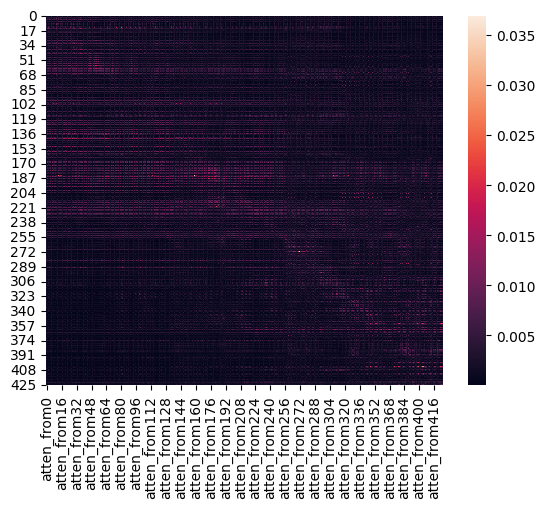

AbbeyGrange:Jack_Croker, ranking [0]


,predicate,whom,subject,why,what,where
0,word.predicate:exist,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Jack_Croker,AbbeyGrange:Jack_Croker,AbbeyGrange:Jack_Croker,AbbeyGrange:Jack_Croker
1,word.predicate:kill,AbbeyGrange:Jack_Croker,AbbeyGrange:Theresa,CrookedMan:Jane,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Lady_Brackenstall
2,word.predicate:go,AllTitle:Holmes,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Lady_Brackenstall,CrookedMan:Barclay,AllTitle:Holmes
3,word.predicate:say,AbbeyGrange:police,AbbeyGrange:cord_of_bell,AbbeyGrange:cord_of_bell,CrookedMan:Jane,CrookedMan:Jane
4,word.predicate:ask,AbbeyGrange:cord_of_bell,DateTime:1898-08-13T03:02:00,AbbeyGrange:Theresa,AllTitle:Holmes,DateTime:1898-08-13T03:02:00
5,word.predicate:find,AbbeyGrange:Criminal,AllTitle:Holmes,ACaseOfIdentity:Windibank,AbbeyGrange:police,AbbeyGrange:Theresa
6,word.predicate:want,AbbeyGrange:Theresa,AbbeyGrange:Criminal,ACaseOfIdentity:Sutherland,DevilsFoot:Owen,CrookedMan:Barclay
7,word.predicate:goOut,AbbeyGrange:Sir_Eustace_Brackenstall,DancingMen:Cubitt,AbbeyGrange:police,ACaseOfIdentity:Sutherland,ACaseOfIdentity:Sutherland
8,word.predicate:notSay,SilverBlaze:Silver_Blaze,AbbeyGrange:Stanley_Hopkins,AbbeyGrange:313,AbbeyGrange:cord_of_bell,AbbeyGrange:Stanley_Hopkins
9,AbbeyGrange:Theresa,SpeckledBand:Helen,ACaseOfIdentity:Windibank,DevilsFoot:lamp,DateTime:1898-08-13T03:02:00,AbbeyGrange:cord_of_bell


406

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from406
183,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.008630
96,AbbeyGrange:352,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.006771
124,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.005312
140,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.004925
103,bos_e,bos_r,bos_e,0.004751
8,AbbeyGrange:336,kgc:what,AbbeyGrange:Theresa,0.004600
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.004580
78,bos_e,bos_r,bos_e,0.004510
290,AbbeyGrange:390,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.004494
346,bos_e,bos_r,bos_e,0.004443


----------


407

['AbbeyGrange:412', 'kgc:subject', 'AbbeyGrange:Voice_of_the_people']

,head,relation,tail,atten_from407
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.012403
314,AbbeyGrange:394,kgc:subject,AbbeyGrange:police,0.012366
342,AbbeyGrange:399a,kgc:subject,AbbeyGrange:Jack_Croker,0.012047
337,AbbeyGrange:399,kgc:subject,AbbeyGrange:everyone,0.011907
339,AbbeyGrange:399,kgc:what,AbbeyGrange:Jack_Croker,0.011430
407,AbbeyGrange:412,kgc:subject,AbbeyGrange:Voice_of_the_people,0.011073
310,AbbeyGrange:393,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010521
357,AbbeyGrange:402,kgc:subject,AbbeyGrange:case,0.009943
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.009746
316,AbbeyGrange:394,kgc:what,AbbeyGrange:Criminal,0.009711


----------


408

['AbbeyGrange:412', 'kgc:hasProperty', 'word.predicate:Voice_of_God']

,head,relation,tail,atten_from408
184,AbbeyGrange:369,kgc:to,AbbeyGrange:Burglary_team_of_Lewisham,0.017633
402,AbbeyGrange:411,kgc:subject,AbbeyGrange:Jack_Croker,0.010024
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.009986
352,AbbeyGrange:401,kgc:subject,AbbeyGrange:Jack_Croker,0.009256
190,AbbeyGrange:370,kgc:to,AbbeyGrange:Lady_Brackenstall,0.009233
342,AbbeyGrange:399a,kgc:subject,AbbeyGrange:Jack_Croker,0.008694
364,AbbeyGrange:403,kgc:whom,AbbeyGrange:Lady_Brackenstall,0.008686
365,AbbeyGrange:403,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008472
181,AbbeyGrange:369,kgc:subject,AbbeyGrange:Jack_Croker,0.008455
359,AbbeyGrange:402,kgc:infoSource,AllTitle:Holmes,0.008084


----------


409

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from409
183,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.007963
96,AbbeyGrange:352,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.006626
124,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.005426
140,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.004851
103,bos_e,bos_r,bos_e,0.004711
8,AbbeyGrange:336,kgc:what,AbbeyGrange:Theresa,0.004497
78,bos_e,bos_r,bos_e,0.004494
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.004469
281,AbbeyGrange:388,kgc:what,AbbeyGrange:387,0.004432
98,bos_e,bos_r,bos_e,0.004412


----------


410

['AbbeyGrange:413', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from410
374,AbbeyGrange:405,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009754
187,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.007751
282,AbbeyGrange:388,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.007181
191,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.006982
296,AbbeyGrange:391,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.006951
185,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.006950
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.006921
169,AbbeyGrange:367,kgc:subject,AbbeyGrange:Jack_Croker,0.006722
290,AbbeyGrange:390,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.006624
190,AbbeyGrange:370,kgc:to,AbbeyGrange:Lady_Brackenstall,0.006575


----------


411

['AbbeyGrange:413', 'kgc:hasPredicate', 'word.predicate:believe']

,head,relation,tail,atten_from411
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.015428
399,AbbeyGrange:410,kgc:what,AbbeyGrange:409,0.013988
407,AbbeyGrange:412,kgc:subject,AbbeyGrange:Voice_of_the_people,0.011845
412,AbbeyGrange:413,kgc:what,AllTitle:Holmes,0.011808
339,AbbeyGrange:399,kgc:what,AbbeyGrange:Jack_Croker,0.010831
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.009805
354,AbbeyGrange:401,kgc:what,AbbeyGrange:appearance,0.009394
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.009240
390,AbbeyGrange:408,kgc:what,AbbeyGrange:Sin_of_Jack_Croker,0.008276
337,AbbeyGrange:399,kgc:subject,AbbeyGrange:everyone,0.007919


----------


412

['AbbeyGrange:413', 'kgc:what', 'AllTitle:Holmes']

,head,relation,tail,atten_from412
412,AbbeyGrange:413,kgc:what,AllTitle:Holmes,0.010682
386,AbbeyGrange:407,kgc:infoSource,AllTitle:Holmes,0.009407
330,AbbeyGrange:397,kgc:infoSource,AllTitle:Holmes,0.009404
327,AbbeyGrange:397,kgc:subject,AllTitle:Holmes,0.008237
65,AbbeyGrange:346,kgc:hasPredicate,word.predicate:stand,0.007761
246,AbbeyGrange:381,kgc:hasPredicate,word.predicate:think,0.007539
419,mask_e,kgc:infoSource,AllTitle:Holmes,0.007258
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.006708
413,AbbeyGrange:413,kgc:infoSource,AllTitle:Holmes,0.006587
325,AbbeyGrange:396,kgc:infoSource,AllTitle:Holmes,0.006470


----------


413

['AbbeyGrange:413', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from413
204,AbbeyGrange:373,kgc:hasPredicate,word.predicate:fray,0.011723
209,AbbeyGrange:374,kgc:hasPredicate,word.predicate:Wonder,0.010774
246,AbbeyGrange:381,kgc:hasPredicate,word.predicate:think,0.010527
285,AbbeyGrange:389,kgc:hasPredicate,word.predicate:canMake,0.009100
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.008723
386,AbbeyGrange:407,kgc:infoSource,AllTitle:Holmes,0.008471
328,AbbeyGrange:397,kgc:hasPredicate,word.predicate:notUnderstand,0.007844
80,AbbeyGrange:349,kgc:hasPredicate,word.predicate:have,0.007810
330,AbbeyGrange:397,kgc:infoSource,AllTitle:Holmes,0.007607
75,AbbeyGrange:348,kgc:hasPredicate,word.predicate:hit,0.007532


----------


414

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from414
183,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.008212
96,AbbeyGrange:352,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.006858
124,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.005645
140,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.005406
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.005218
281,AbbeyGrange:388,kgc:what,AbbeyGrange:387,0.004914
290,AbbeyGrange:390,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.004877
103,bos_e,bos_r,bos_e,0.004581
78,bos_e,bos_r,bos_e,0.004380
346,bos_e,bos_r,bos_e,0.004340


----------


415

['AbbeyGrange:414', 'kgc:subject', 'AbbeyGrange:police']

,head,relation,tail,atten_from415
282,AbbeyGrange:388,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.011775
374,AbbeyGrange:405,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010549
296,AbbeyGrange:391,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010017
310,AbbeyGrange:393,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.009751
255,AbbeyGrange:383,kgc:subject,AbbeyGrange:Jack_Croker,0.009127
290,AbbeyGrange:390,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008887
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.008512
253,AbbeyGrange:382,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008170
187,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.007682
365,AbbeyGrange:403,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007502


----------


416

['AbbeyGrange:414', 'kgc:hasPredicate', 'word.predicate:cannotFind']

,head,relation,tail,atten_from416
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.015109
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.014581
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.013747
399,AbbeyGrange:410,kgc:what,AbbeyGrange:409,0.013261
363,AbbeyGrange:403,kgc:what,AbbeyGrange:accomplice,0.011719
417,AbbeyGrange:414,kgc:what,AbbeyGrange:False_charge_person,0.010021
390,AbbeyGrange:408,kgc:what,AbbeyGrange:Sin_of_Jack_Croker,0.009797
354,AbbeyGrange:401,kgc:what,AbbeyGrange:appearance,0.009606
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.009213
339,AbbeyGrange:399,kgc:what,AbbeyGrange:Jack_Croker,0.009132


----------


417

['AbbeyGrange:414', 'kgc:what', 'AbbeyGrange:False_charge_person']

,head,relation,tail,atten_from417
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.017758
384,AbbeyGrange:407,kgc:what,AbbeyGrange:truth,0.013254
417,AbbeyGrange:414,kgc:what,AbbeyGrange:False_charge_person,0.012274
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.011916
412,AbbeyGrange:413,kgc:what,AllTitle:Holmes,0.011789
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.011410
365,AbbeyGrange:403,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010811
390,AbbeyGrange:408,kgc:what,AbbeyGrange:Sin_of_Jack_Croker,0.010101
253,AbbeyGrange:382,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009967
301,AbbeyGrange:392,kgc:what,AbbeyGrange:392a,0.009873


----------


418

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from418
183,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.008542
96,AbbeyGrange:352,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.006955
124,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.005569
140,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.005505
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.005478
281,AbbeyGrange:388,kgc:what,AbbeyGrange:387,0.004885
103,bos_e,bos_r,bos_e,0.004609
290,AbbeyGrange:390,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.004598
8,AbbeyGrange:336,kgc:what,AbbeyGrange:Theresa,0.004422
346,bos_e,bos_r,bos_e,0.004421


----------


419

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from419
384,AbbeyGrange:407,kgc:what,AbbeyGrange:truth,0.009882
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.009779
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.008231
385,AbbeyGrange:407,kgc:to,AbbeyGrange:Stanley_Hopkins,0.007999
382,AbbeyGrange:407,kgc:subject,AllTitle:Holmes,0.007625
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.007419
386,AbbeyGrange:407,kgc:infoSource,AllTitle:Holmes,0.007156
380,AbbeyGrange:406,kgc:infoSource,AllTitle:Holmes,0.007053
209,AbbeyGrange:374,kgc:hasPredicate,word.predicate:Wonder,0.007026
390,AbbeyGrange:408,kgc:what,AbbeyGrange:Sin_of_Jack_Croker,0.006994


----------


420

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from420
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.025754
399,AbbeyGrange:410,kgc:what,AbbeyGrange:409,0.017722
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.012998
354,AbbeyGrange:401,kgc:what,AbbeyGrange:appearance,0.012138
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.011933
344,AbbeyGrange:399a,kgc:what,AbbeyGrange:appearance,0.011853
363,AbbeyGrange:403,kgc:what,AbbeyGrange:accomplice,0.011427
364,AbbeyGrange:403,kgc:whom,AbbeyGrange:Lady_Brackenstall,0.010407
421,mask_e,kgc:whom,AbbeyGrange:Sir_Eustace_Brackenstall,0.008981
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.008809


----------


421

['mask_e', 'kgc:whom', 'AbbeyGrange:Sir_Eustace_Brackenstall']

,head,relation,tail,atten_from421
374,AbbeyGrange:405,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010233
255,AbbeyGrange:383,kgc:subject,AbbeyGrange:Jack_Croker,0.009680
352,AbbeyGrange:401,kgc:subject,AbbeyGrange:Jack_Croker,0.008227
282,AbbeyGrange:388,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008189
342,AbbeyGrange:399a,kgc:subject,AbbeyGrange:Jack_Croker,0.007941
187,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.007922
206,AbbeyGrange:373,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007885
284,AbbeyGrange:389,kgc:subject,AbbeyGrange:sailor,0.007827
203,AbbeyGrange:373,kgc:subject,AbbeyGrange:Jack_Croker,0.007216
185,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007170


----------


422

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from422
374,AbbeyGrange:405,kgc:infoSource,AbbeyGrange:Jack_Croker,0.013572
282,AbbeyGrange:388,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010225
296,AbbeyGrange:391,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010177
185,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009029
384,AbbeyGrange:407,kgc:what,AbbeyGrange:truth,0.008613
310,AbbeyGrange:393,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008517
187,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.008378
191,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008124
255,AbbeyGrange:383,kgc:subject,AbbeyGrange:Jack_Croker,0.007960
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.007930


----------


423

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from423
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.021683
354,AbbeyGrange:401,kgc:what,AbbeyGrange:appearance,0.014258
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.012018
384,AbbeyGrange:407,kgc:what,AbbeyGrange:truth,0.011239
317,AbbeyGrange:394,kgc:infoSource,AllTitle:Holmes,0.011100
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.010783
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.010766
340,AbbeyGrange:399,kgc:infoSource,AllTitle:Holmes,0.010635
359,AbbeyGrange:402,kgc:infoSource,AllTitle:Holmes,0.010594
399,AbbeyGrange:410,kgc:what,AbbeyGrange:409,0.010538


----------


424

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from424
354,AbbeyGrange:401,kgc:what,AbbeyGrange:appearance,0.022871
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.019294
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.016847
384,AbbeyGrange:407,kgc:what,AbbeyGrange:truth,0.012417
424,mask_e,kgc:what,mask_e,0.011362
412,AbbeyGrange:413,kgc:what,AllTitle:Holmes,0.010306
317,AbbeyGrange:394,kgc:infoSource,AllTitle:Holmes,0.010083
363,AbbeyGrange:403,kgc:what,AbbeyGrange:accomplice,0.009818
301,AbbeyGrange:392,kgc:what,AbbeyGrange:392a,0.009626
290,AbbeyGrange:390,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.009608


----------


425

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from425
354,AbbeyGrange:401,kgc:what,AbbeyGrange:appearance,0.021487
404,AbbeyGrange:411,kgc:what,AbbeyGrange:sin,0.017788
379,AbbeyGrange:406,kgc:what,AbbeyGrange:Sincerity_of_Jack_Croker,0.014782
361,AbbeyGrange:403,kgc:subject,AbbeyGrange:police,0.013554
399,AbbeyGrange:410,kgc:what,AbbeyGrange:409,0.010892
384,AbbeyGrange:407,kgc:what,AbbeyGrange:truth,0.010723
329,AbbeyGrange:397,kgc:what,AbbeyGrange:396,0.010632
310,AbbeyGrange:393,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.009508
303,AbbeyGrange:392a,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.008241
364,AbbeyGrange:403,kgc:whom,AbbeyGrange:Lady_Brackenstall,0.008218


----------


In [29]:
title = 'AbbeyGrange'
victim_name = 'Sir_Eustace_Brackenstall'
killer_name = 'Jack_Croker'
last_index = 414
story_len = 80

df_ranking_AbbeyGrange, df_attension_AbbeyGrange = main_func01(title, victim_name, killer_name, last_index, story_len)

### 入院患者
Who killed Blessington? (criminal & explanation)
被害者: Blessington
犯人: 3人
犯行動機: 

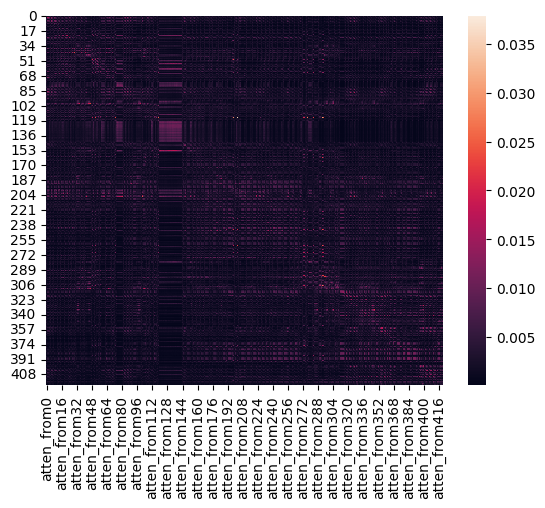

ResidentPatient:, ranking []


,predicate,whom,subject,why,what,where
0,word.predicate:kill,ResidentPatient:Blessington,ResidentPatient:Young_man,ResidentPatient:Percy_Trevelyan,SilverBlaze:Silver_Blaze,ResidentPatient:Blessington_room
1,word.predicate:exist,ResidentPatient:Young_man,ResidentPatient:Elderly_man,DevilsFoot:Sterndale,AllTitle:Watson,SilverBlaze:John_Straker
2,word.predicate:examine,AllTitle:Holmes,ResidentPatient:Blessington,ResidentPatient:Blessington,SilverBlaze:John_Straker,CrookedMan:Nancy
3,word.predicate:cut,ResidentPatient:Elderly_man,ResidentPatient:Helper_boy,word.predicate:escape,DevilsFoot:Owen,ResidentPatient:Percy_Trevelyan
4,word.predicate:sit,DevilsFoot:Sterndale,AllTitle:Holmes,AllTitle:Watson,ResidentPatient:Blessington,DevilsFoot:Owen
5,word.predicate:notHear,ResidentPatient:Percy_Trevelyan,DevilsFoot:Sterndale,word.predicate:exist,DevilsFoot:House_of_Trigenis,DevilsFoot:Sterndale
6,word.predicate:say,ResidentPatient:Helper_boy,AllTitle:Watson,SpeckledBand:mansion_of_Roylott,ACaseOfIdentity:Hosmer,SilverBlaze:Silver_Blaze
7,ResidentPatient:Young_man,CrookedMan:Nancy,ResidentPatient:Percy_Trevelyan,DevilsFoot:House_of_Trigenis,word.predicate:die,DateTime:1883-04-01T14:00:00
8,word.predicate:die,AbbeyGrange:Criminal,CrookedMan:Nancy,ResidentPatient:Helper_boy,DateTime:1883-04-01T14:00:00,SpeckledBand:Julia_s_bedroom
9,word.predicate:have,AbbeyGrange:Lady_Brackenstall,word.predicate:examine,DevilsFoot:Owen,DevilsFoot:Sterndale,AllTitle:Watson


401

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from401
345,ResidentPatient:310,kgc:hasProperty,word.predicate:happen,0.005318
90,ResidentPatient:265,kgc:hasProperty,word.predicate:notExist,0.005107
81,bos_e,bos_r,bos_e,0.004371
74,ResidentPatient:262,kgc:hasPredicate,word.predicate:say,0.004333
144,bos_e,bos_r,bos_e,0.004196
72,bos_e,bos_r,bos_e,0.004174
113,bos_e,bos_r,bos_e,0.004164
117,bos_e,bos_r,bos_e,0.004158
109,bos_e,bos_r,bos_e,0.004098
11,bos_e,bos_r,bos_e,0.004098


----------


402

['ResidentPatient:322', 'kgc:subject', 'ResidentPatient:Blessington']

,head,relation,tail,atten_from402
410,ResidentPatient:324,kgc:subject,ResidentPatient:Blessington,0.014834
341,ResidentPatient:309a,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.011548
380,ResidentPatient:318,kgc:subject,ResidentPatient:Helper_boy,0.009747
24,ResidentPatient:251,kgc:subject,ResidentPatient:Blessington,0.009524
406,ResidentPatient:323,kgc:subject,ResidentPatient:Blessington,0.009128
337,ResidentPatient:309,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.008704
402,ResidentPatient:322,kgc:subject,ResidentPatient:Blessington,0.008522
298,ResidentPatient:301,kgc:time,DateTime:1889-10-21T12:00:00,0.008088
384,ResidentPatient:319,kgc:subject,ResidentPatient:Young_man,0.008042
70,ResidentPatient:261,kgc:subject,ResidentPatient:Blessington,0.007931


----------


403

['ResidentPatient:322', 'kgc:hasProperty', 'word.predicate:know']

,head,relation,tail,atten_from403
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.014418
319,ResidentPatient:305,kgc:hasProperty,word.predicate:Sutton,0.012054
330,ResidentPatient:307,kgc:hasProperty,word.predicate:Cartwright,0.011543
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.011342
356,ResidentPatient:312,kgc:what,ResidentPatient:decisive_factor,0.011301
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.011031
87,ResidentPatient:264,kgc:hasProperty,word.predicate:clearly,0.010496
359,ResidentPatient:313,kgc:hasProperty,word.predicate:worst_villain,0.010275
329,ResidentPatient:307,kgc:subject,ResidentPatient:5th_man,0.010224
399,ResidentPatient:321,kgc:hasProperty,word.predicate:succeed,0.009818


----------


404

['ResidentPatient:322', 'kgc:what', 'ResidentPatient:Source_Date']

,head,relation,tail,atten_from404
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.016614
202,ResidentPatient:283,kgc:infoSource,AllTitle:Holmes,0.012440
205,ResidentPatient:284,kgc:hasProperty,word.predicate:thick,0.011247
84,ResidentPatient:263,kgc:what,ResidentPatient:Blessington,0.011194
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.010402
201,ResidentPatient:283,kgc:hasProperty,word.predicate:notHear,0.010188
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.010167
10,ResidentPatient:247,kgc:what,ResidentPatient:two_butts_of_Cigar,0.009927
356,ResidentPatient:312,kgc:what,ResidentPatient:decisive_factor,0.009406
223,ResidentPatient:287,kgc:what,ResidentPatient:cigar,0.008912


----------


405

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from405
90,ResidentPatient:265,kgc:hasProperty,word.predicate:notExist,0.005499
345,ResidentPatient:310,kgc:hasProperty,word.predicate:happen,0.004990
81,bos_e,bos_r,bos_e,0.004226
144,bos_e,bos_r,bos_e,0.004089
117,bos_e,bos_r,bos_e,0.004067
74,ResidentPatient:262,kgc:hasPredicate,word.predicate:say,0.004059
113,bos_e,bos_r,bos_e,0.004055
72,bos_e,bos_r,bos_e,0.004044
95,ResidentPatient:266,kgc:hasProperty,word.predicate:exist,0.004044
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.003996


----------


406

['ResidentPatient:323', 'kgc:subject', 'ResidentPatient:Blessington']

,head,relation,tail,atten_from406
410,ResidentPatient:324,kgc:subject,ResidentPatient:Blessington,0.015339
341,ResidentPatient:309a,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.013840
406,ResidentPatient:323,kgc:subject,ResidentPatient:Blessington,0.011689
402,ResidentPatient:322,kgc:subject,ResidentPatient:Blessington,0.010417
358,ResidentPatient:313,kgc:subject,ResidentPatient:Blessington,0.009177
337,ResidentPatient:309,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.009175
86,ResidentPatient:264,kgc:subject,ResidentPatient:Facts,0.009068
380,ResidentPatient:318,kgc:subject,ResidentPatient:Helper_boy,0.009001
24,ResidentPatient:251,kgc:subject,ResidentPatient:Blessington,0.008817
384,ResidentPatient:319,kgc:subject,ResidentPatient:Young_man,0.008801


----------


407

['ResidentPatient:323', 'kgc:hasProperty', 'word.predicate:know']

,head,relation,tail,atten_from407
359,ResidentPatient:313,kgc:hasProperty,word.predicate:worst_villain,0.015216
319,ResidentPatient:305,kgc:hasProperty,word.predicate:Sutton,0.014708
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.014096
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.013794
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.013523
87,ResidentPatient:264,kgc:hasProperty,word.predicate:clearly,0.012882
330,ResidentPatient:307,kgc:hasProperty,word.predicate:Cartwright,0.012170
83,ResidentPatient:263,kgc:hasProperty,word.predicate:save,0.011820
356,ResidentPatient:312,kgc:what,ResidentPatient:decisive_factor,0.010847
84,ResidentPatient:263,kgc:what,ResidentPatient:Blessington,0.010659


----------


408

['ResidentPatient:323',
 'kgc:what',
 'ResidentPatient:The_strength_of_the_fellow_revenge']

,head,relation,tail,atten_from408
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.014715
202,ResidentPatient:283,kgc:infoSource,AllTitle:Holmes,0.011775
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.011741
201,ResidentPatient:283,kgc:hasProperty,word.predicate:notHear,0.011708
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.011173
84,ResidentPatient:263,kgc:what,ResidentPatient:Blessington,0.010697
205,ResidentPatient:284,kgc:hasProperty,word.predicate:thick,0.010492
319,ResidentPatient:305,kgc:hasProperty,word.predicate:Sutton,0.009911
298,ResidentPatient:301,kgc:time,DateTime:1889-10-21T12:00:00,0.009199
356,ResidentPatient:312,kgc:what,ResidentPatient:decisive_factor,0.008942


----------


409

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from409
90,ResidentPatient:265,kgc:hasProperty,word.predicate:notExist,0.005047
345,ResidentPatient:310,kgc:hasProperty,word.predicate:happen,0.004896
81,bos_e,bos_r,bos_e,0.004226
74,ResidentPatient:262,kgc:hasPredicate,word.predicate:say,0.004146
117,bos_e,bos_r,bos_e,0.004077
144,bos_e,bos_r,bos_e,0.004077
113,bos_e,bos_r,bos_e,0.004068
72,bos_e,bos_r,bos_e,0.004049
109,bos_e,bos_r,bos_e,0.003971
11,bos_e,bos_r,bos_e,0.003954


----------


410

['ResidentPatient:324', 'kgc:subject', 'ResidentPatient:Blessington']

,head,relation,tail,atten_from410
341,ResidentPatient:309a,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.016987
410,ResidentPatient:324,kgc:subject,ResidentPatient:Blessington,0.015233
337,ResidentPatient:309,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.010110
380,ResidentPatient:318,kgc:subject,ResidentPatient:Helper_boy,0.009835
384,ResidentPatient:319,kgc:subject,ResidentPatient:Young_man,0.009610
406,ResidentPatient:323,kgc:subject,ResidentPatient:Blessington,0.009607
416,mask_e,kgc:whom,ResidentPatient:Blessington,0.009564
390,ResidentPatient:319a,kgc:subject,ResidentPatient:Young_man,0.009157
358,ResidentPatient:313,kgc:subject,ResidentPatient:Blessington,0.008887
383,ResidentPatient:319,kgc:subject,ResidentPatient:Elderly_man,0.008819


----------


411

['ResidentPatient:324', 'kgc:hasProperty', 'word.predicate:want']

,head,relation,tail,atten_from411
359,ResidentPatient:313,kgc:hasProperty,word.predicate:worst_villain,0.011514
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.010796
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.010739
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.009721
412,ResidentPatient:324,kgc:what,ResidentPatient:324a,0.009694
256,ResidentPatient:293a,kgc:what,ResidentPatient:Instead_of_tools_hanging_stand,0.009127
319,ResidentPatient:305,kgc:hasProperty,word.predicate:Sutton,0.008909
356,ResidentPatient:312,kgc:what,ResidentPatient:decisive_factor,0.008667
205,ResidentPatient:284,kgc:hasProperty,word.predicate:thick,0.008389
191,ResidentPatient:281,kgc:to,ResidentPatient:Blessington_room,0.008210


----------


412

['ResidentPatient:324', 'kgc:what', 'ResidentPatient:324a']

,head,relation,tail,atten_from412
387,ResidentPatient:319,kgc:what,ResidentPatient:319a,0.013228
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.012152
223,ResidentPatient:287,kgc:what,ResidentPatient:cigar,0.010939
376,ResidentPatient:317,kgc:what,ResidentPatient:Imprisonment_of_14_years,0.010516
393,ResidentPatient:319a,kgc:what,ResidentPatient:Blessington,0.009441
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.009433
359,ResidentPatient:313,kgc:hasProperty,word.predicate:worst_villain,0.009302
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.009242
61,ResidentPatient:258,kgc:what,ResidentPatient:261,0.008996
202,ResidentPatient:283,kgc:infoSource,AllTitle:Holmes,0.008692


----------


413

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from413
345,ResidentPatient:310,kgc:hasProperty,word.predicate:happen,0.004561
90,ResidentPatient:265,kgc:hasProperty,word.predicate:notExist,0.004428
74,ResidentPatient:262,kgc:hasPredicate,word.predicate:say,0.004308
49,ResidentPatient:256,kgc:hasPredicate,word.predicate:examine,0.004133
81,bos_e,bos_r,bos_e,0.004133
113,bos_e,bos_r,bos_e,0.003996
117,bos_e,bos_r,bos_e,0.003989
144,bos_e,bos_r,bos_e,0.003974
72,bos_e,bos_r,bos_e,0.003970
109,bos_e,bos_r,bos_e,0.003902


----------


414

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from414
298,ResidentPatient:301,kgc:time,DateTime:1889-10-21T12:00:00,0.012914
115,ResidentPatient:270,kgc:hasPredicate,word.predicate:cannotFind,0.009533
243,ResidentPatient:292,kgc:hasPredicate,word.predicate:prepare,0.009503
348,ResidentPatient:310,kgc:time,DateTime:1875-01-01T00:00:00,0.009059
375,ResidentPatient:317,kgc:hasPredicate,word.predicate:receive,0.008928
386,ResidentPatient:319,kgc:hasPredicate,word.predicate:try,0.008814
304,ResidentPatient:302,kgc:time,DateTime:1889-10-21T16:15:00,0.008570
376,ResidentPatient:317,kgc:what,ResidentPatient:Imprisonment_of_14_years,0.008413
49,ResidentPatient:256,kgc:hasPredicate,word.predicate:examine,0.007520
310,ResidentPatient:303,kgc:time,DateTime:1889-10-21T13:00:00,0.007429


----------


415

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from415
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.012441
387,ResidentPatient:319,kgc:what,ResidentPatient:319a,0.010419
223,ResidentPatient:287,kgc:what,ResidentPatient:cigar,0.010250
412,ResidentPatient:324,kgc:what,ResidentPatient:324a,0.009875
376,ResidentPatient:317,kgc:what,ResidentPatient:Imprisonment_of_14_years,0.009214
41,ResidentPatient:255,kgc:subject,ResidentPatient:Criminal,0.009076
416,mask_e,kgc:whom,ResidentPatient:Blessington,0.008523
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.008362
393,ResidentPatient:319a,kgc:what,ResidentPatient:Blessington,0.007900
319,ResidentPatient:305,kgc:hasProperty,word.predicate:Sutton,0.007737


----------


416

['mask_e', 'kgc:whom', 'ResidentPatient:Blessington']

,head,relation,tail,atten_from416
373,ResidentPatient:317,kgc:subject,ResidentPatient:Young_man,0.010794
310,ResidentPatient:303,kgc:time,DateTime:1889-10-21T13:00:00,0.010526
384,ResidentPatient:319,kgc:subject,ResidentPatient:Young_man,0.010302
390,ResidentPatient:319a,kgc:subject,ResidentPatient:Young_man,0.010047
389,ResidentPatient:319a,kgc:subject,ResidentPatient:Elderly_man,0.009620
348,ResidentPatient:310,kgc:time,DateTime:1875-01-01T00:00:00,0.009619
410,ResidentPatient:324,kgc:subject,ResidentPatient:Blessington,0.008825
341,ResidentPatient:309a,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.008783
383,ResidentPatient:319,kgc:subject,ResidentPatient:Elderly_man,0.008746
391,ResidentPatient:319a,kgc:subject,ResidentPatient:Helper_boy,0.008577


----------


417

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from417
341,ResidentPatient:309a,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.011425
384,ResidentPatient:319,kgc:subject,ResidentPatient:Young_man,0.010559
390,ResidentPatient:319a,kgc:subject,ResidentPatient:Young_man,0.010516
310,ResidentPatient:303,kgc:time,DateTime:1889-10-21T13:00:00,0.010195
389,ResidentPatient:319a,kgc:subject,ResidentPatient:Elderly_man,0.009872
348,ResidentPatient:310,kgc:time,DateTime:1875-01-01T00:00:00,0.009464
391,ResidentPatient:319a,kgc:subject,ResidentPatient:Helper_boy,0.009454
337,ResidentPatient:309,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.009339
383,ResidentPatient:319,kgc:subject,ResidentPatient:Elderly_man,0.009287
373,ResidentPatient:317,kgc:subject,ResidentPatient:Young_man,0.009220


----------


418

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from418
334,ResidentPatient:308,kgc:whom,ResidentPatient:Moderator_of_Tobin,0.009306
298,ResidentPatient:301,kgc:time,DateTime:1889-10-21T12:00:00,0.009067
387,ResidentPatient:319,kgc:what,ResidentPatient:319a,0.009042
310,ResidentPatient:303,kgc:time,DateTime:1889-10-21T13:00:00,0.009013
412,ResidentPatient:324,kgc:what,ResidentPatient:324a,0.008983
348,ResidentPatient:310,kgc:time,DateTime:1875-01-01T00:00:00,0.008723
99,ResidentPatient:266,kgc:time,DateTime:1889-10-21T05:00:00,0.008690
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.008175
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.007748
191,ResidentPatient:281,kgc:to,ResidentPatient:Blessington_room,0.007214


----------


419

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from419
387,ResidentPatient:319,kgc:what,ResidentPatient:319a,0.013350
298,ResidentPatient:301,kgc:time,DateTime:1889-10-21T12:00:00,0.011756
286,ResidentPatient:299,kgc:when,ResidentPatient:1889-10-21T15:00:00,0.010216
287,ResidentPatient:299,kgc:time,DateTime:1889-10-21T15:00:00,0.009854
376,ResidentPatient:317,kgc:what,ResidentPatient:Imprisonment_of_14_years,0.009560
297,ResidentPatient:301,kgc:when,ResidentPatient:1889-10-21T12:00:00,0.009442
310,ResidentPatient:303,kgc:time,DateTime:1889-10-21T13:00:00,0.008859
355,ResidentPatient:312,kgc:hasProperty,word.predicate:lack,0.008484
399,ResidentPatient:321,kgc:hasProperty,word.predicate:succeed,0.007832
304,ResidentPatient:302,kgc:time,DateTime:1889-10-21T16:15:00,0.007568


----------


420

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from420
387,ResidentPatient:319,kgc:what,ResidentPatient:319a,0.011137
341,ResidentPatient:309a,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.009831
348,ResidentPatient:310,kgc:time,DateTime:1875-01-01T00:00:00,0.009650
310,ResidentPatient:303,kgc:time,DateTime:1889-10-21T13:00:00,0.009149
399,ResidentPatient:321,kgc:hasProperty,word.predicate:succeed,0.008429
298,ResidentPatient:301,kgc:time,DateTime:1889-10-21T12:00:00,0.008406
395,ResidentPatient:320,kgc:subject,ResidentPatient:319a,0.008405
404,ResidentPatient:322,kgc:what,ResidentPatient:Source_Date,0.007995
337,ResidentPatient:309,kgc:subject,ResidentPatient:Worthington_bank_Robbers,0.007900
408,ResidentPatient:323,kgc:what,ResidentPatient:The_strength_of_the_fellow_rev...,0.007838


----------


In [30]:
title = 'ResidentPatient'
victim_name = 'Blessington'
killer_name = ''
last_index = 324
story_len = 80

df_ranking_Blessington, df_attension_Blessington = main_func01(title, victim_name, killer_name, last_index, story_len)

### 白銀
Who took out the White Silver Blaze? (criminal & explanation) 
被害者: Silver_Blaze
犯人: 
犯行動機: 

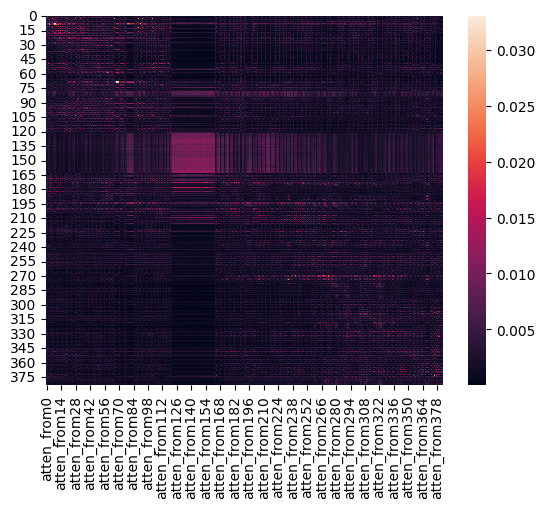

,predicate,whom,subject,why,what,where
0,word.predicate:have,SilverBlaze:Silver_Blaze,SilverBlaze:Silver_Blaze,SpeckledBand:mansion_of_Roylott,SilverBlaze:Silver_Blaze,SilverBlaze:John_Straker
1,SilverBlaze:Night_of_the_incident,SilverBlaze:Fitzroy_Simpson,SilverBlaze:John_Straker,SpeckledBand:bed,SilverBlaze:John_Straker,AllTitle:Holmes
2,word.predicate:say,SilverBlaze:John_Straker,SilverBlaze:Fitzroy_Simpson,SpeckledBand:Julia_s_bedroom,AllTitle:Holmes,SpeckledBand:Julia_s_bedroom
3,word.predicate:find,AllTitle:Holmes,AllTitle:Holmes,AllTitle:Holmes,SilverBlaze:Fitzroy_Simpson,DateTime:1881-04-01T00:00:00
4,word.predicate:ask,AllTitle:Watson,AllTitle:Watson,SilverBlaze:Colonel_Ross,AllTitle:Watson,SilverBlaze:Silver_Blaze
5,word.predicate:go,ACaseOfIdentity:Hosmer,SilverBlaze:Silas_Brown,word.predicate:escape,ACaseOfIdentity:Hosmer,SpeckledBand:Roylott
6,word.predicate:try,AbbeyGrange:Lady_Brackenstall,CrookedMan:Barclay,AllTitle:Watson,CrookedMan:Barclay,SilverBlaze:Colonel_Ross
7,word.predicate:exist,SilverBlaze:Ned_Hunter,SilverBlaze:Gregory_Inspector,ResidentPatient:Helper_boy,SpeckledBand:Julia_s_bedroom,ResidentPatient:Blessington
8,word.predicate:examine,SilverBlaze:Silas_Brown,SilverBlaze:Ned_Hunter,SilverBlaze:John_Straker,AbbeyGrange:Lady_Brackenstall,SilverBlaze:stable
9,word.predicate:get,DevilsFoot:Brenda,AbbeyGrange:Lady_Brackenstall,word.predicate:louder,DancingMen:Cubitt,SpeckledBand:corridor


364

['SilverBlaze:394', 'kgc:hasPredicate', 'word.predicate:buy']

,head,relation,tail,atten_from364
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.014575
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.011584
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.010953
246,SilverBlaze:371a,kgc:what,SilverBlaze:Silver_Blaze,0.010089
254,SilverBlaze:373,kgc:what,SilverBlaze:Injustice,0.009790
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.009703
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.008748
250,SilverBlaze:372,kgc:what,SilverBlaze:Lame,0.008588
314,SilverBlaze:385,kgc:what,SilverBlaze:legs_of_Silver_Blaze,0.007880
53,SilverBlaze:341,kgc:subject,SilverBlaze:Colonel_Ross,0.007818


----------


365

['SilverBlaze:394', 'kgc:what', 'SilverBlaze:Expensive_clothes']

,head,relation,tail,atten_from365
224,SilverBlaze:366,kgc:what,SilverBlaze:Lot_of_money,0.019052
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.014648
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.013110
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.012521
53,SilverBlaze:341,kgc:subject,SilverBlaze:Colonel_Ross,0.009331
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.009312
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.008762
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.008176
222,SilverBlaze:366,kgc:subject,SilverBlaze:horse_trainer,0.007835
228,SilverBlaze:367,kgc:what,SilverBlaze:Horse,0.007682


----------


366

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from366
42,SilverBlaze:338,kgc:hasPredicate,word.predicate:exist,0.006342
23,SilverBlaze:333,kgc:to,SilverBlaze:Youth_stables_number,0.005736
75,bos_e,bos_r,bos_e,0.005348
8,SilverBlaze:331,kgc:what,SilverBlaze:331a,0.005217
85,bos_e,bos_r,bos_e,0.005137
29,bos_e,bos_r,bos_e,0.005089
56,bos_e,bos_r,bos_e,0.005055
0,bos_e,bos_r,bos_e,0.004938
24,bos_e,bos_r,bos_e,0.004912
70,bos_e,bos_r,bos_e,0.004907


----------


367

['SilverBlaze:395', 'kgc:subject', 'SilverBlaze:John_Straker']

,head,relation,tail,atten_from367
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.015337
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.014397
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.011748
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.011647
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.011270
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010597
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.010405
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.009857
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.009321
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.008304


----------


368

['SilverBlaze:395', 'kgc:hasPredicate', 'word.predicate:have']

,head,relation,tail,atten_from368
274,SilverBlaze:377,kgc:hasProperty,word.predicate:dark,0.016944
190,SilverBlaze:359b,kgc:hasProperty,word.predicate:Curry_dish,0.013793
187,SilverBlaze:359a,kgc:hasProperty,SilverBlaze:359b,0.013142
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.011912
31,SilverBlaze:335,kgc:hasProperty,word.predicate:lame,0.011335
238,SilverBlaze:370,kgc:hasProperty,word.predicate:wacky,0.011241
344,SilverBlaze:390a,kgc:what,SilverBlaze:thigh_of_John_Straker,0.010161
337,SilverBlaze:389,kgc:what,SilverBlaze:The_forehead_of_John_Straker,0.010060
269,SilverBlaze:376,kgc:what,SilverBlaze:candle,0.010041
235,SilverBlaze:369,kgc:what,SilverBlaze:knife,0.008965


----------


369

['SilverBlaze:395', 'kgc:what', 'SilverBlaze:debt']

,head,relation,tail,atten_from369
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.009276
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.009080
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.008624
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.008153
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.007864
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.007699
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.007389
357,SilverBlaze:393,kgc:what,SilverBlaze:the_hat_decoration_shop,0.007147
194,SilverBlaze:360,kgc:what,SilverBlaze:John_Straker,0.006855
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.006574


----------


370

['SilverBlaze:395', 'kgc:why', 'SilverBlaze:394']

,head,relation,tail,atten_from370
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.009316
100,SilverBlaze:348a,kgc:to,SilverBlaze:Horseracing,0.006814
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.006530
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.006339
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.006055
250,SilverBlaze:372,kgc:what,SilverBlaze:Lame,0.005971
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.005858
98,SilverBlaze:348a,kgc:subject,SilverBlaze:Silver_Blaze,0.005810
246,SilverBlaze:371a,kgc:what,SilverBlaze:Silver_Blaze,0.005702
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.005674


----------


371

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from371
8,SilverBlaze:331,kgc:what,SilverBlaze:331a,0.005822
23,SilverBlaze:333,kgc:to,SilverBlaze:Youth_stables_number,0.005690
42,SilverBlaze:338,kgc:hasPredicate,word.predicate:exist,0.005676
75,bos_e,bos_r,bos_e,0.005191
85,bos_e,bos_r,bos_e,0.004991
29,bos_e,bos_r,bos_e,0.004908
56,bos_e,bos_r,bos_e,0.004901
0,bos_e,bos_r,bos_e,0.004796
24,bos_e,bos_r,bos_e,0.004764
70,bos_e,bos_r,bos_e,0.004742


----------


372

['SilverBlaze:396', 'kgc:subject', 'SilverBlaze:Colonel_Ross']

,head,relation,tail,atten_from372
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.017832
351,SilverBlaze:392,kgc:subject,SilverBlaze:John_Straker,0.015255
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.014331
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.014249
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.011662
346,SilverBlaze:391,kgc:subject,SilverBlaze:John_Straker,0.010835
312,SilverBlaze:385,kgc:subject,SilverBlaze:John_Straker,0.010788
53,SilverBlaze:341,kgc:subject,SilverBlaze:Colonel_Ross,0.010689
252,SilverBlaze:373,kgc:subject,SilverBlaze:People,0.010213
303,SilverBlaze:383a,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.010033


----------


373

['SilverBlaze:396', 'kgc:hasPredicate', 'word.predicate:ask']

,head,relation,tail,atten_from373
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.008945
344,SilverBlaze:390a,kgc:what,SilverBlaze:thigh_of_John_Straker,0.008900
254,SilverBlaze:373,kgc:what,SilverBlaze:Injustice,0.008498
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.007707
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.007485
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.007214
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.007024
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.006912
51,SilverBlaze:340,kgc:on,SilverBlaze:Brown_horse,0.006709
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.006674


----------


374

['SilverBlaze:396', 'kgc:what', 'SilverBlaze:Place_of_the_horse']

,head,relation,tail,atten_from374
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.014151
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.010376
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.008752
161,SilverBlaze:354,kgc:what,SilverBlaze:394,0.008676
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.008308
215,SilverBlaze:364,kgc:what,SilverBlaze:Dog_of_the_stables,0.008168
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.008054
153,SilverBlaze:354,kgc:what,SilverBlaze:386,0.008022
135,SilverBlaze:354,kgc:what,SilverBlaze:368,0.008000
151,SilverBlaze:354,kgc:what,SilverBlaze:384,0.007932


----------


375

['SilverBlaze:396', 'kgc:to', 'AllTitle:Holmes']

,head,relation,tail,atten_from375
373,SilverBlaze:396,kgc:hasPredicate,word.predicate:ask,0.026520
352,SilverBlaze:392,kgc:hasPredicate,word.predicate:practice,0.019100
308,SilverBlaze:384,kgc:hasPredicate,word.predicate:pick,0.018093
193,SilverBlaze:360,kgc:hasPredicate,word.predicate:suspect,0.013524
347,SilverBlaze:391,kgc:hasPredicate,word.predicate:takeOff,0.011626
356,SilverBlaze:393,kgc:hasPredicate,word.predicate:go,0.011223
364,SilverBlaze:394,kgc:hasPredicate,word.predicate:buy,0.011193
103,SilverBlaze:349,kgc:hasPredicate,word.predicate:catch,0.011088
360,SilverBlaze:393a,kgc:hasPredicate,word.predicate:confirm,0.010392
223,SilverBlaze:366,kgc:hasPredicate,word.predicate:get,0.009754


----------


376

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from376
8,SilverBlaze:331,kgc:what,SilverBlaze:331a,0.005739
23,SilverBlaze:333,kgc:to,SilverBlaze:Youth_stables_number,0.005704
42,SilverBlaze:338,kgc:hasPredicate,word.predicate:exist,0.005367
75,bos_e,bos_r,bos_e,0.005252
85,bos_e,bos_r,bos_e,0.005039
29,bos_e,bos_r,bos_e,0.004998
56,bos_e,bos_r,bos_e,0.004986
0,bos_e,bos_r,bos_e,0.004870
24,bos_e,bos_r,bos_e,0.004864
70,bos_e,bos_r,bos_e,0.004863


----------


377

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from377
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.014056
351,SilverBlaze:392,kgc:subject,SilverBlaze:John_Straker,0.013245
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.011891
346,SilverBlaze:391,kgc:subject,SilverBlaze:John_Straker,0.010760
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.010337
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010254
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.009763
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.009464
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.009124
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.008249


----------


378

['mask_e', 'kgc:hasPredicate', 'word.predicate:bring']

,head,relation,tail,atten_from378
344,SilverBlaze:390a,kgc:what,SilverBlaze:thigh_of_John_Straker,0.013948
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.013810
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.013415
314,SilverBlaze:385,kgc:what,SilverBlaze:legs_of_Silver_Blaze,0.012739
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.012346
309,SilverBlaze:384,kgc:what,SilverBlaze:tie,0.011409
269,SilverBlaze:376,kgc:what,SilverBlaze:candle,0.010751
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.010702
337,SilverBlaze:389,kgc:what,SilverBlaze:The_forehead_of_John_Straker,0.010516
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.010508


----------


379

['mask_e', 'kgc:whom', 'mask_e']

,head,relation,tail,atten_from379
333,SilverBlaze:388,kgc:when,SilverBlaze:387,0.021062
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.015080
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010405
326,SilverBlaze:387a,kgc:subject,SilverBlaze:Silver_Blaze,0.009876
330,SilverBlaze:388,kgc:subject,SilverBlaze:John_Straker,0.009211
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.008174
312,SilverBlaze:385,kgc:subject,SilverBlaze:John_Straker,0.008088
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.007924
303,SilverBlaze:383a,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.007587
321,SilverBlaze:387,kgc:subject,SilverBlaze:Silver_Blaze,0.007361


----------


380

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from380
333,SilverBlaze:388,kgc:when,SilverBlaze:387,0.015483
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.013277
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.012219
307,SilverBlaze:384,kgc:subject,SilverBlaze:John_Straker,0.010644
363,SilverBlaze:394,kgc:subject,SilverBlaze:John_Straker,0.009703
372,SilverBlaze:396,kgc:subject,SilverBlaze:Colonel_Ross,0.009697
348,SilverBlaze:391,kgc:what,SilverBlaze:cloak,0.009206
173,SilverBlaze:357,kgc:subject,SilverBlaze:Fitzroy_Simpson,0.009035
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.008144
351,SilverBlaze:392,kgc:subject,SilverBlaze:John_Straker,0.008122


----------


381

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from381
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.007931
374,SilverBlaze:396,kgc:what,SilverBlaze:Place_of_the_horse,0.007328
235,SilverBlaze:369,kgc:what,SilverBlaze:knife,0.007225
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.007006
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.006932
203,SilverBlaze:361,kgc:what,SilverBlaze:menu,0.006799
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.006748
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.006442
100,SilverBlaze:348a,kgc:to,SilverBlaze:Horseracing,0.006386
160,SilverBlaze:354,kgc:what,SilverBlaze:393,0.006373


----------


382

['mask_e', 'kgc:what', 'SilverBlaze:Silver_Blaze']

,head,relation,tail,atten_from382
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.013675
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.012921
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.011427
224,SilverBlaze:366,kgc:what,SilverBlaze:Lot_of_money,0.010027
361,SilverBlaze:393a,kgc:what,SilverBlaze:394,0.010017
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.009632
228,SilverBlaze:367,kgc:what,SilverBlaze:Horse,0.009522
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.008574
367,SilverBlaze:395,kgc:subject,SilverBlaze:John_Straker,0.008262
235,SilverBlaze:369,kgc:what,SilverBlaze:knife,0.007805


----------


383

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from383
233,SilverBlaze:369,kgc:subject,SilverBlaze:Corpse_of_John_Straker,0.008949
369,SilverBlaze:395,kgc:what,SilverBlaze:debt,0.008379
224,SilverBlaze:366,kgc:what,SilverBlaze:Lot_of_money,0.008349
117,SilverBlaze:353,kgc:subject,SilverBlaze:Colonel_Ross,0.008093
55,SilverBlaze:341,kgc:what,SilverBlaze:342,0.007215
321,SilverBlaze:387,kgc:subject,SilverBlaze:Silver_Blaze,0.007094
228,SilverBlaze:367,kgc:what,SilverBlaze:Horse,0.007058
365,SilverBlaze:394,kgc:what,SilverBlaze:Expensive_clothes,0.006979
171,SilverBlaze:356,kgc:what,SilverBlaze:Taste_of_opium,0.006852
353,SilverBlaze:392,kgc:what,SilverBlaze:Surgery_of_tendon,0.006800


----------


In [31]:
victim = 'SilverBlaze:Silver_Blaze'
df_ranking_SilverBlaze, df_attension_SilverBlaze = make_ranking(
    'SilverBlaze:330', 'SilverBlaze:396', BRING, MASK_E, MASK_E, MASK_E, victim, MASK_E)

display(df_ranking_SilverBlaze.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_SilverBlaze)
for i in range(len_-20, len_):
    display(i, df_attension_SilverBlaze.iloc[i,:3].tolist())
    display(df_attension_SilverBlaze.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 花嫁失踪事件（同一事件）
hozmaの失踪の名瀬を探る
被害者: ACaseOfIdentity:Hozma
犯人: 
犯行動機: 

In [ ]:
victim = 'ACaseOfIdentity:Hosmer'
df_ranking_ACaseOfIdentity, df_attension_ACaseOfIdentity = make_ranking(
    'ACaseOfIdentity:510', 'ACaseOfIdentity:578', HIDE, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_ACaseOfIdentity.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_ACaseOfIdentity)
for i in range(len_-20, len_):
    display(i, df_attension_ACaseOfIdentity.iloc[i,:3].tolist())
    display(df_attension_ACaseOfIdentity.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")
